<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression or any other suitable classifier.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

## QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

#### Load in the the data of scraped salaries

In [1]:
# Load contents of scraped data file 
df = pd.read_csv('job_data_final1.csv')

In [2]:
# Short EDA of loaded data
df.head()

,City,Company,Location,Reviews,Salary,Summary,Title,Indeed_Estimate
0,Dallas,Hitachi Consulting Corporation US,"Dallas, TX",153.0,124000,"The Data Scientist designs, builds and maintai...",Sr Consultant Data Scientist,1
1,Dallas,7-Eleven,"Irving, TX",7125.0,115000,Work closely with data engineersto ensure the ...,Sr Data Scientist,1
2,Dallas,Workbridge Associates,"Dallas, TX",36.0,107500,"Experience with data modeling, analysis, progr...",Full-Stack Software Engineer (Predictive Analy...,0
3,Dallas,A+ Consulting,"Plano, TX",NaN,150000,This is a direct hire position - not contract....,Principal Machine Learning/Nlp Engineer-Architect,0
4,Dallas,Platform by Per Scholas,"Dallas, TX",NaN,55000,"Java, Oracle DB, Shell Scripting, SDLC and Cod...",Data Scientist/Analyst,0


In [3]:
df.shape

(323, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 8 columns):
City               323 non-null object
Company            323 non-null object
Location           323 non-null object
Reviews            220 non-null float64
Salary             323 non-null int64
Summary            323 non-null object
Title              323 non-null object
Indeed_Estimate    323 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 20.3+ KB


In [5]:
df.isnull().sum()

City                 0
Company              0
Location             0
Reviews            103
Salary               0
Summary              0
Title                0
Indeed_Estimate      0
dtype: int64

In [6]:
df.describe()

,Reviews,Salary,Indeed_Estimate
count,220.000000,323.000000,323.000000
mean,1234.645455,108397.108359,0.337461
std,4820.001272,39944.322269,0.473577
min,2.000000,29500.000000,0.000000
25%,16.500000,75158.000000,0.000000
50%,62.500000,110000.000000,0.000000
75%,495.000000,135000.000000,1.000000
max,54889.000000,250000.000000,1.000000


#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [7]:
# Define mask to identify salaries greater than or equal to the median 
mask = df.Salary >= df.Salary.median()

print(f'The median salary is ${int(df.Salary.median())}.')

# Insert new column into df, where True indicates the salary is greater than or equal to
# the median salary, and False indicates the salary is less than the median
df['High_Salary'] = mask


The median salary is $110000.


As expected, this median salary calculation is aligned with the 50th percentile in the df.describe() above.

In [8]:
df.head(10)

,City,Company,Location,Reviews,Salary,Summary,Title,Indeed_Estimate,High_Salary
0,Dallas,Hitachi Consulting Corporation US,"Dallas, TX",153.0,124000,"The Data Scientist designs, builds and maintai...",Sr Consultant Data Scientist,1,True
1,Dallas,7-Eleven,"Irving, TX",7125.0,115000,Work closely with data engineersto ensure the ...,Sr Data Scientist,1,True
2,Dallas,Workbridge Associates,"Dallas, TX",36.0,107500,"Experience with data modeling, analysis, progr...",Full-Stack Software Engineer (Predictive Analy...,0,False
3,Dallas,A+ Consulting,"Plano, TX",NaN,150000,This is a direct hire position - not contract....,Principal Machine Learning/Nlp Engineer-Architect,0,True
4,Dallas,Platform by Per Scholas,"Dallas, TX",NaN,55000,"Java, Oracle DB, Shell Scripting, SDLC and Cod...",Data Scientist/Analyst,0,False
5,Dallas,HRK Solutions,"Dallas, TX",NaN,102500,"Data Scientist - Python, R, & SAS. ETL / Data ...",Sr. Software Engineer,0,False
6,Dallas,The We Are Big Data Scientists Company,"Dallas, TX",NaN,77000,We employ numerous roles including data scient...,Technical Writer I,0,False
7,Dallas,Camden Kelly,"Dallas, TX",NaN,105000,Effectively present the story that the data te...,Data Scientist – Articulate Data’S Story & Get...,0,False
8,Dallas,Arbor Diagnostics,"Dallas, TX 75234",NaN,135000,Managing the implementation of data warehouse ...,Clinical Informatics Director,0,True
9,Dallas,Hunt Around Solutions,"Dallas, TX",NaN,150000,Interact with customers’ Data Scientists and B...,Presales Big Data Consultant,0,True


In [9]:
df.tail(10)

,City,Company,Location,Reviews,Salary,Summary,Title,Indeed_Estimate,High_Salary
313,Austin,DDMR,"Austin, TX",NaN,70000,You'll be dealing with very technical engineer...,Technical Product Manager - Data Services,0,False
314,Austin,DDMR,"Austin, TX",NaN,70000,You'll be dealing with very technical engineer...,Technical Product Manager - Analytics Solutions,0,False
315,Austin,Interactive Resources,"Austin, TX",11.0,137500,Product development engineer or scientist in a...,Principal Polymer Engineer,0,True
316,Austin,Prestige Staffing,"Austin, TX 78759 (Arboretum area)",127.0,120000,Responsible for coaching and leading the Data ...,Data Science Manager,0,True
317,Austin,Pisika,"Austin, TX 78758 (North Austin area)",NaN,95000,"Build dashboards, data visualizations, and too...",Data Scientist,0,False
318,Austin,Prestige Staffing,"Austin, TX 78759 (Arboretum area)",127.0,125000,"Python, Lab, Data Science, consulting, compute...",Data Scientist,0,True
319,Austin,Meador Staffing of Austin,"Austin, TX",NaN,137500,Experience in big data and machine learning sy...,Online Marketing Scientist/Engineer,0,True
320,Austin,General Assembly,"Austin, TX",131.0,142500,We are looking for a Data Scientist to facilit...,Lead Data Science Immersive Instructor,1,True
321,Austin,DMGT,"Austin, TX",3.0,116000,Senior Data Scientist. The Senior Data Scienti...,Senior Data Scientist,1,True
322,Austin,SparkCognition,"Austin, TX 78759 (Arboretum area)",3.0,110000,SparkCognition is seeking an innovative data s...,Senior Data Scientist – Malware & Security,1,True


#### What is the baseline accuracy for this model?

In [10]:
baseline_accuracy = round(df.High_Salary.value_counts().max() / df.High_Salary.count(),2)

print(f'The baseline accuracy of this model predicting High or Low salary is {baseline_accuracy}.')

The baseline accuracy of this model predicting High or Low salary is 0.5.


# Answer
The baseline accuracy of a model is the accuracy that can be achieved by the model predicting the majority class for every data point.

A baseline accuracy of 0.5 is to be expected for this model since the median salary was used as the threshold for classifying 
salaries as high or low - meaning 50% of salaries are above this threshold, and 50% are below, resulting in a 
50:50 probability of randomly selecting the 'majority' class.
    
In this case, the odds ratio (i.e. P(y=1) / (1- P(y=1)) is ~1. This means that the majority class is equally likely to happen, as it is not to happen.

### Create a classification model to predict High/Low salary. 


#### Model based on location:

- Start by ONLY using the location as a feature. 
- Use logistic regression with both statsmodels and sklearn.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.

In [11]:
# Binarise the High_Salary column in the df, such that high salaries are class 1
# and low salaries are class 0
df.High_Salary = df.High_Salary.map(lambda x: 1 if x == True else 0) 

In [12]:
df.High_Salary.value_counts()

1    163
0    160
Name: High_Salary, dtype: int64

There is a slight inequality between the number of salaries above and below the median as there are some salaries equal to the median.  Based on the definition I've used to classify High and Low salaries, these will be classified as High - hence there are slightly more salaries classified as High, than Low. 

In [13]:
# Calculate the probability of a job being highly paid for each city 

cities = df.City.unique().tolist()

for city in cities:
    print(f'P(High Salary | city = {city}): {round(np.mean(df[df.City == city].High_Salary),2)}')
 

P(High Salary | city = Dallas): 0.47
P(High Salary | city = Chicago): 0.62
P(High Salary | city = Seattle): 0.63
P(High Salary | city = Los Angeles): 0.59
P(High Salary | city = Pittsburgh): 0.0
P(High Salary | city = Portland): 0.6
P(High Salary | city = Philadelphia): 0.48
P(High Salary | city = Houston): 0.4
P(High Salary | city = New York): 0.41
P(High Salary | city = Atlanta): 0.53
P(High Salary | city = Denver): 0.47
P(High Salary | city = San Francisco): 0.79
P(High Salary | city = Miami): 0.06
P(High Salary | city = Phoenix): 0.4
P(High Salary | city = Austin): 0.56


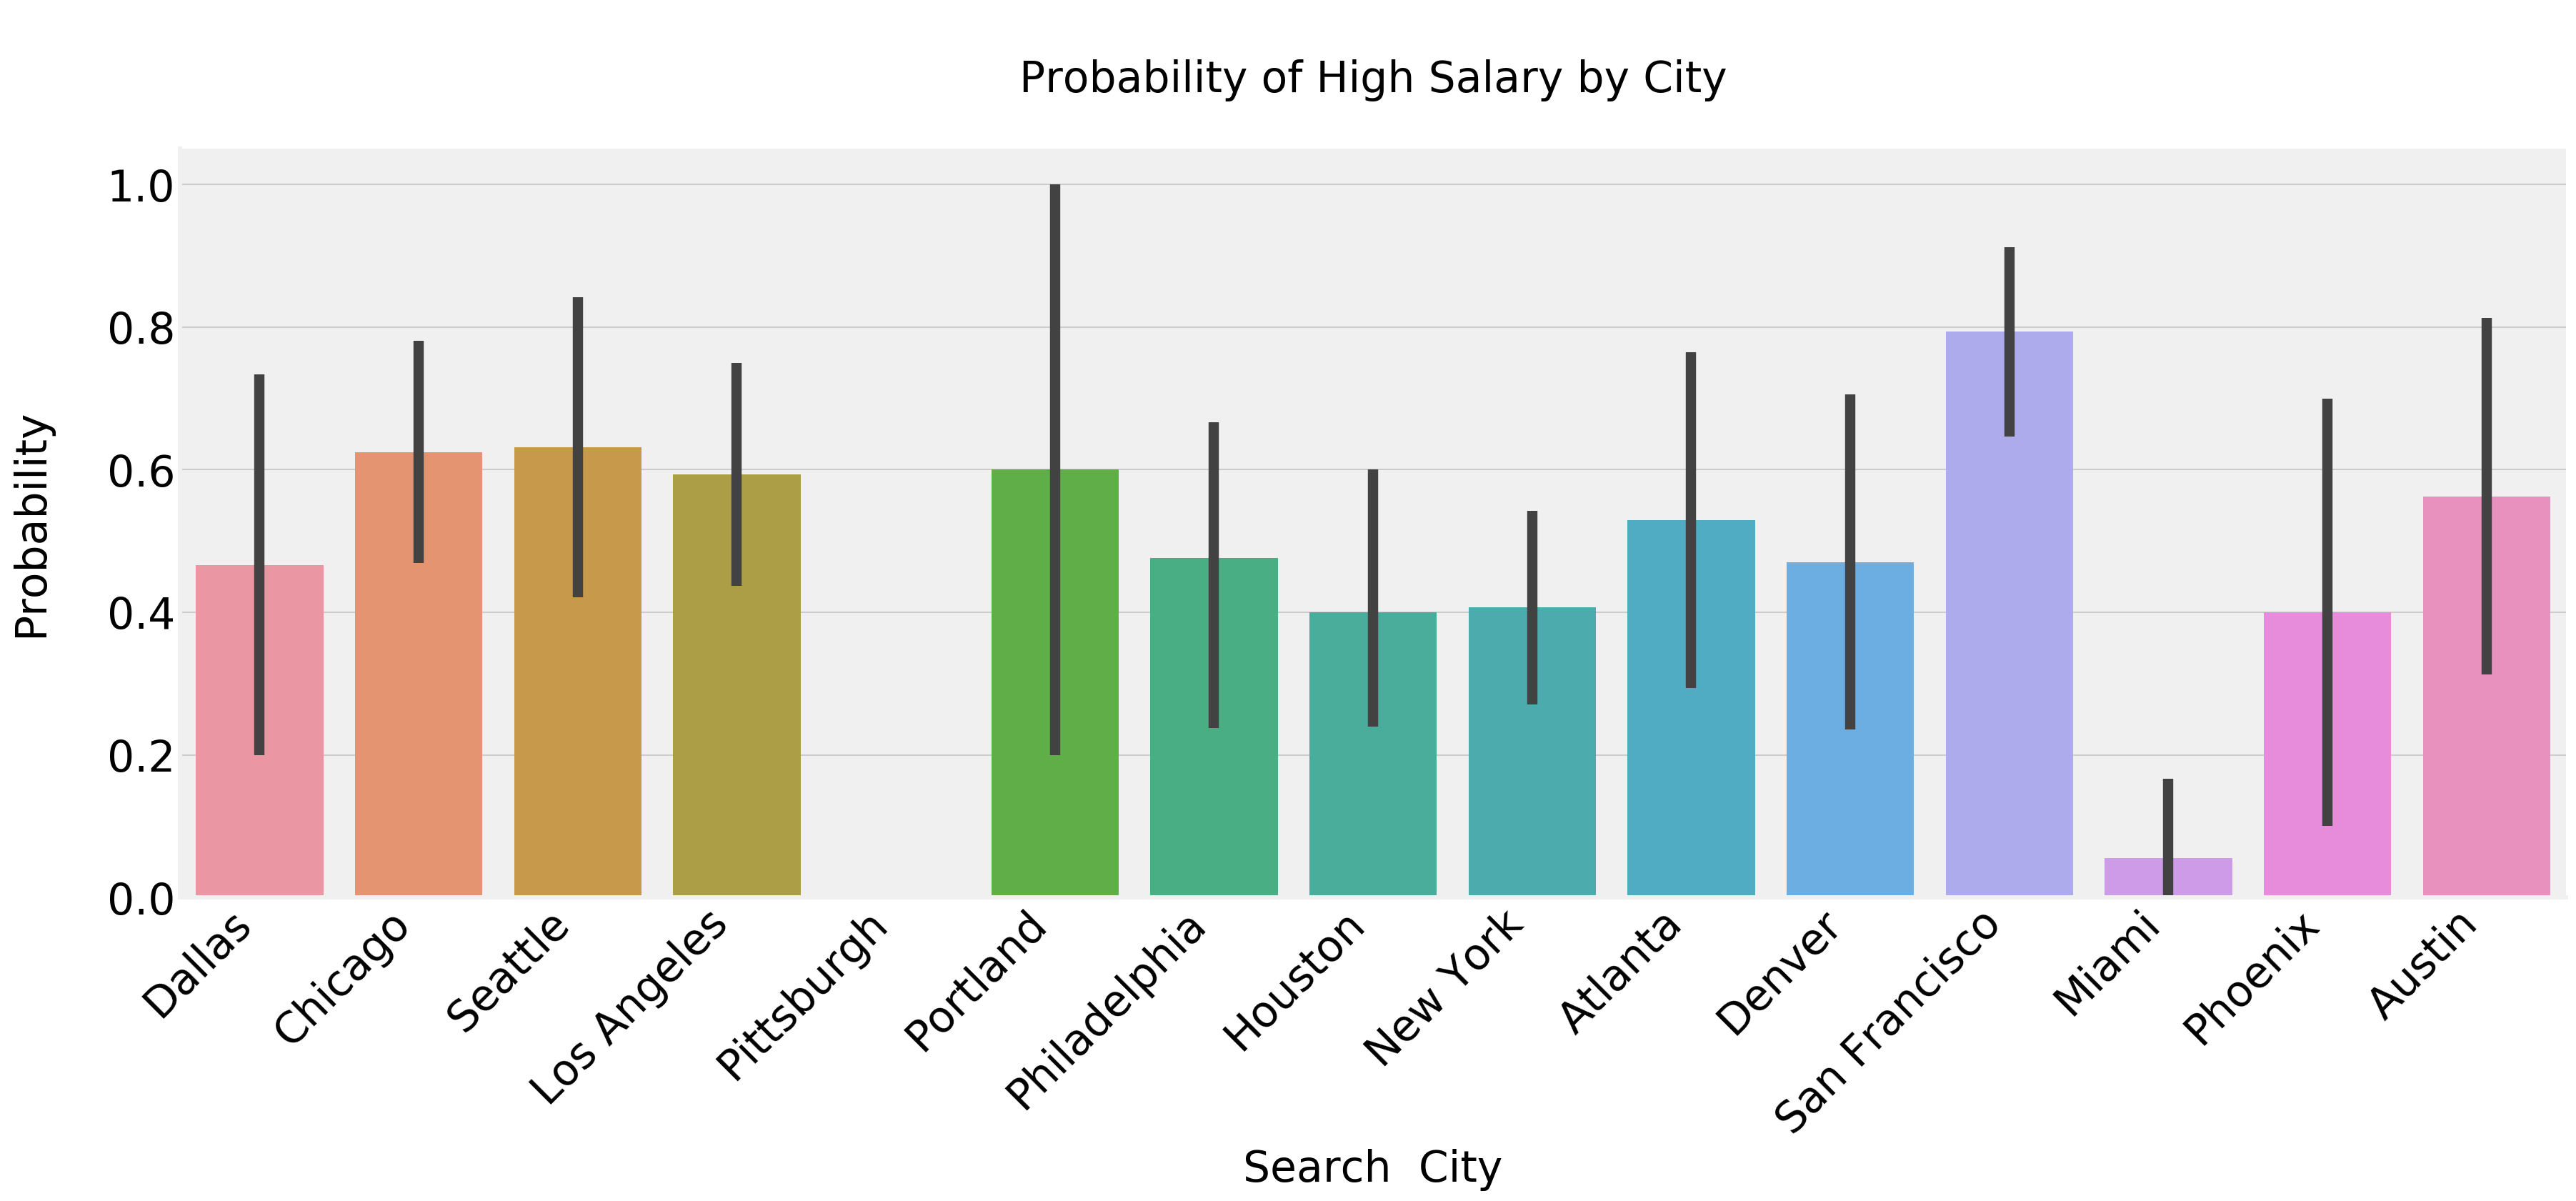

In [14]:
# Display probability of High Salary by City in a factor plot

sns.factorplot(x='City', y='High_Salary', data=df, kind='bar', aspect=3, size=8, ci=95, 
              ).set_xticklabels(rotation=45, horizontalalignment='right',
              fontsize=30).set_yticklabels(fontsize=30)
plt.xlabel('Search  City',fontsize=30)
plt.ylabel('Probability\n',fontsize=30)
plt.title('\nProbability of High Salary by City\n').set_fontsize(30) ;

# Answer
The probabilities displayed in the factor plot are aligned with the manual calculation of the probability of the majority class above.

The size of the 95% confidence interval displayed in the plot is strongly influenced by the number of records for each city (see breakdown in cell below).  In calculating the mean of the 1s and 0s that differentiate a High and Low salary, the confidence interval is smaller for cities with more data points.

In [15]:
# Print number of data point for each city to get a feel for the Salary data
df.groupby('City')['Salary'].count()

City
Atlanta          17
Austin           16
Chicago          32
Dallas           15
Denver           17
Houston          25
Los Angeles      32
Miami            18
New York         59
Philadelphia     21
Phoenix          10
Pittsburgh        3
Portland          5
San Francisco    34
Seattle          19
Name: Salary, dtype: int64

In [16]:
# Print number of High Salaries each city to get a feel for the Salary data
df.groupby('City')['High_Salary'].sum()

City
Atlanta           9
Austin            9
Chicago          20
Dallas            7
Denver            8
Houston          10
Los Angeles      19
Miami             1
New York         24
Philadelphia     10
Phoenix           4
Pittsburgh        0
Portland          3
San Francisco    27
Seattle          12
Name: High_Salary, dtype: int64

##### Logistic Regression with sklearn (predictor = City)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import recall_score, accuracy_score, roc_curve, auc

In [18]:
# Create predictor matrix and target array

# Define target array
y = df['High_Salary']

# Define predictor matrix
X = df[['City']]

# Dumify categorical field in predictor data.  Drop San Francisco column as this has the highest 
# probability of having jobs with a high salary.  Dropping this column will help with 
# the interpretability of the coefficients
X_dumified = pd.get_dummies(X)
X_dumified.drop('City_San Francisco', axis=1, inplace=True)


In [19]:
X_dumified.head()

,City_Atlanta,City_Austin,City_Chicago,City_Dallas,City_Denver,City_Houston,City_Los Angeles,City_Miami,City_New York,City_Philadelphia,City_Phoenix,City_Pittsburgh,City_Portland,City_Seattle
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Since all of the predictors have the same units, standardising our predictors is not absolutely necessary in this case.

In [20]:
# Create a train-test split on dumified predictor and target data 
# Assign random state to enable reporoducible results
# Stratify on target variable to maintain proportionate representation of target classes

X_train, X_test, y_train, y_test = train_test_split(X_dumified, y, test_size=0.4,
                                                    stratify=y, random_state=5)

In [21]:
# Instantiate Logistic Regression Model, with very minimal/no regularisation

logreg = LogisticRegression(C=10**10)

I'm intentionally minimising regularistion in this initial model fit as I'd like to see the model results without it.  

I'll apply regularisation using GridSearch later.

In [23]:
# Review cross validation accuracy scores of model on training data.  
# Shuffle, as data is likely to be ordered by date.

scores = cross_val_score(logreg, X_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=5))
print('Accuracy scores: ', scores)
print('Mean accuracy score: ', scores.mean())

Accuracy scores:  [0.55384615 0.625      0.625     ]
Mean accuracy score:  0.6012820512820513


Model appears to be performing OK - definitely better than the baseline, as evidenced by the mean accuracy score being greater than the 0.5 baseline. 

In [24]:
# Fit model to full training data set
logreg.fit(X_train, y_train)

LogisticRegression(C=10000000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [25]:
# Print accuracy of model for fit on entire training data set
print(f'The accuracy of the model on the training data is: \
{round(logreg.score(X_train, y_train),2)}.')

The accuracy of the model on the training data is: 0.67.


The model is performing quite well on the train set, with an accuracy score greater than the baseline of 0.5.

In [26]:
# Define predictions from logreg model, based on the predictor test data
predictions = logreg.predict(X_test)

In [28]:
# Print accuracy of model for the test set
print(f'The accuracy of the model on the test set is: \
{round(accuracy_score(y_test, predictions),2)}.')

The accuracy of the model on the test set is: 0.52.


The model hasn't generalised well to the test data and is only performing marginally better than the baseline model.

The model may be overfitted to the training data.  The small number of data points for some cities is also problematic, as cities with very few data points may not be sufficiently represented in the train-test splits to maintain their signal for both high and low salary classes.  Stratifying on the traget variable promotes proportional representation of high and low salaries however, the proportionate representation of cities may not have been sufficiently maintained in this relatively small dataset. 

In [29]:
# Cross check accuracy score calcuated using sklearn with manual calculation
print(f'Manually calculated accuracy score: {round((predictions == y_test).sum()/len(y_test),2)}')

Manually calculated accuracy score: 0.52


The manually calculated accuracy score agrees with that calculated using sklearn! :-)  
    
This accuracy score means that 52% of the High/Low salary classes are being correctly predicted from the logreg model, using the test data set.

In [30]:
# Display confusion matrix
confusion = confusion_matrix(y_test, predictions)
pd.DataFrame(confusion, columns=['Predicted Low Salary', 'Predicted High Salary'], 
             index=['Actual Low Salary', 'Actual High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,36,28
Actual High Salary,34,32


In [31]:
# Cross check accuracy score with data in confusion matrix
print(f'Accuracy score calculated from confusion matrix: \
{round((confusion[0][0] + confusion[1][1])/confusion.sum(),2)}')

Accuracy score calculated from confusion matrix: 0.52


Accuracy score confirmed as aligned with the confusion matrix.

Reviewing the confusion matrix reveals that the model is doing a better job of predicting low salaries vs high salaries.  This observation is confirmed with the calculations below, which shows the specificity score (true negative rate) is higher than the recall score (true positive rate).

In [32]:
# Print recall score / true positive rate (tp / tp + fn)
print(f'Recall score/true positive rate is: {round(recall_score(y_test, predictions),2)}')

# Print specicifity / true negative rate (tn / tn + fp)
print(f'Specicity score/true negative rate is: {round(recall_score(y_test==0, predictions==0),2)}')

Recall score/true positive rate is: 0.48
Specicity score/true negative rate is: 0.56


In [33]:
# View recall scores in classification report 
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.51      0.56      0.54        64
          1       0.53      0.48      0.51        66

avg / total       0.52      0.52      0.52       130



In [34]:
# Use Grid Search to search Logistic Regression hyperparameters to see if model can be improved
# Define logistic regression hyperparameters.  Center C around 0 to maximise regularisation.
salary_gs_params = {'penalty':['l1','l2'],
                    'solver':['liblinear'], 
                    'C':np.logspace(-10, 10, 5000),
                    'fit_intercept':[True, False]}

I recognise that the C parameter specified above produces a large number of models with only marginal differences in regularisation strengths however, based on experimentation with the GridSearch parameters, I found that very small differences in regularisation strength resulted in notable differences in the best mean cross validated scores in this case, hence I've been very granular with the regularisation strengths.  

I've also intentionally selected the maximum value of the logspace to equal the regularisation strength I used in the 'unregularised' model above, as I wanted to test as much of the full range of regularisation range less than the 'starting point' above as possible.

In [35]:
# Create gridsearch object using LogisticRegression() and the hyperparamater dictionary above
salary_gs = GridSearchCV(LogisticRegression(), salary_gs_params, 
                         n_jobs=-1, cv=3, verbose=1)

In [36]:
# Fit gridsearch object to training data
salary_gs.fit(X_train, y_train)

Fitting 3 folds for each of 20000 candidates, totalling 60000 fits


[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 17720 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 42720 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 60000 out of 60000 | elapsed:   42.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': array([1.00000e-10, 1.00925e-10, ..., 9.90830e+09, 1.00000e+10]), 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [37]:
# Print out best mean cross validated score
salary_gs.best_score_     

0.6269430051813472

This mean cross validated score is higher than the cross validated score calculated above.  I'm happy with this, and aren't getting any higher than this with different hyperparamaters.

In [38]:
# Print out best parameters
salary_gs.best_params_   

{'C': 4486734654.102896,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'liblinear'}

The C score is in the upper end of the logspace range. Based on experimentation with the hyperparamaters, it seems that the cross validated accuracy scores of the model has plateaued out with variations in the regularisation strength (i.e. the optimum C value keeps moving towards the end of the logspace range with very slight changes in the accuracy score).  Based on this, I'm happy to accept these paramaters as my best model paramaters.

In [39]:
# Assign optimum Logisitc Regression estimator to best_logreg
best_logreg = salary_gs.best_estimator_

In [40]:
# Print accuracy score of best log reg model for fit on entire training data set
print(f'The accuracy of the model on the training data is: \
{round(best_logreg.score(X_train, y_train),2)}.')

The accuracy of the model on the training data is: 0.67.


This accuracy score is the same as the accuracy score achieved with the unregularised model above - which isn't a huge surprise, since the regularisation strength of this best log reg model is very weak (i.e. very similar to the unregularised model used above).

In [41]:
# Print accuracy score of best log reg model for fit on the test data
print(f'Accuracy score of optimum Logistic Regression model on test data: \
{round(best_logreg.score(X_test, y_test),2)}')

Accuracy score of optimum Logistic Regression model on test data: 0.52


As expected, the accuracy score of the best log reg model on the test set is the same as that achieved with the original unregularised model above.

I'll now try an experiment with the regularisation hyperparameter centered aound 0 to maximum regularisation strength to see what difference this makes.  Again, I'm keeping the increments in regularisation strength very small, resulting in a large number of GridSearch models.

In [42]:
# Test gridsearch results again with hyperparameters defined to focus on higher regularisation strengths
# Fit model and print optimum log reg model parameters.  
salary_gs_params1 = {'penalty':['l1','l2'],
                    'solver':['liblinear'], 
                    'C':np.logspace(-3, 3, 6000),
                    'fit_intercept':[True, False]}

salary_gs1 = GridSearchCV(LogisticRegression(), salary_gs_params1, 
                         n_jobs=-1, cv=3, verbose=1)

salary_gs1.fit(X_train, y_train)

salary_gs1.best_params_ 


Fitting 3 folds for each of 24000 candidates, totalling 72000 fits


[Parallel(n_jobs=-1)]: Done 2540 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 16040 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 38540 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 70040 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 72000 out of 72000 | elapsed:   49.3s finished


{'C': 0.26509644308320623,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'liblinear'}

The optimum C value is very nicely positioned within the hyperparamater range.

In [43]:
# Print out best mean cross validated score
salary_gs1.best_score_   

0.6113989637305699

The mean cross validated accuracy score is less than that achieved with the GridSearch above, which included lower levels of regularisation within its hyperparamaters.

In [44]:
# Test the optimum Logistic Regression resulting from this second GridSearch
# Assign estimator to best_logreg1
best_logreg1 = salary_gs1.best_estimator_

# Print accuracy score of best log reg model for fit on entire training data set
print(f'The accuracy of the model on the training data is: \
{round(best_logreg1.score(X_train, y_train),2)}.')

# Print accuracy score of best log reg model for fit on the test data
print(f'Accuracy score of optimum Logistic Regression model on test data: \
{round(best_logreg1.score(X_test, y_test),2)}')



The accuracy of the model on the training data is: 0.67.
Accuracy score of optimum Logistic Regression model on test data: 0.52


Once again, there is very little difference in the accuracy scores of this optimum log reg model on the training and test data.  

The model fits well to the training data and is performing much better than the baseline model, but it doesn't generalise well to the test data - which performs only slightly better on the test data than the baseline.

In [45]:
# View gridsearch results 
# gs_results = pd.DataFrame(salary_gs.cv_results_)
# gs_results.head()

# Plot mean test score vs C hyperparameter
# gs_results.groupby(['param_fit_intercept','param_penalty']).plot(x='param_C',y='mean_test_score',logx=True)
# plt.legend()
# plt.show()

In [46]:
# Print coefficients from original (i.e. prior to GridSerarch) unregularised model

# Define DF with coefficients from unregularised log reg model
df_coeff = pd.DataFrame({'Coefficients':logreg.coef_[0], 'city':X_train.columns})
df_coeff.sort_values(by='Coefficients', ascending=False, inplace=True)

print('Logreg intercept:', logreg.intercept_) 
print('\n\n')
print('Logreg coefs:')
df_coeff

Logreg intercept: [1.33500107]



Logreg coefs:


,Coefficients,city
0,0.610909,City_Atlanta
12,-0.236389,City_Portland
6,-0.715962,City_Los Angeles
2,-0.728865,City_Chicago
1,-1.335001,City_Austin
3,-1.335001,City_Dallas
9,-1.558145,City_Philadelphia
4,-1.558145,City_Denver
10,-1.740466,City_Phoenix
8,-1.814574,City_New York


Unlike linear regression, which determines predictor coefficients to mininimse the loss function, Logistic Regression determines predictor coefficients to maximize the likelihood that the predicted probabilities give the correct class. The optimal case would be that the predicted probabilities for all class one observations (high salaries) are one and the predicted probabilities for all class zero observations (low salaries) are zero.

The coefficients in a logistic regression model represent the change in log-odds due to the input variables.  

In the case above, the intercept (1.33500107) is equivalent to the predicted log-odds of a High Salary for the city of San Francisco (i.e. the dropped column when the City predictor was dumified, and equivalent to all other predictor variables being 0).

In [47]:
# Calculate the modeled probability of a high salary in San Francisco using the intercept from the logreg model
modeled_sanfran_prob = round(float(1/(1+np.exp(-(logreg.intercept_)))),2)
print(f'The modeled probability of a high salary in San Francisco is {modeled_sanfran_prob}.')

The modeled probability of a high salary in San Francisco is 0.79.


This agrees with the probability calculated from the observations for San Francisco above.

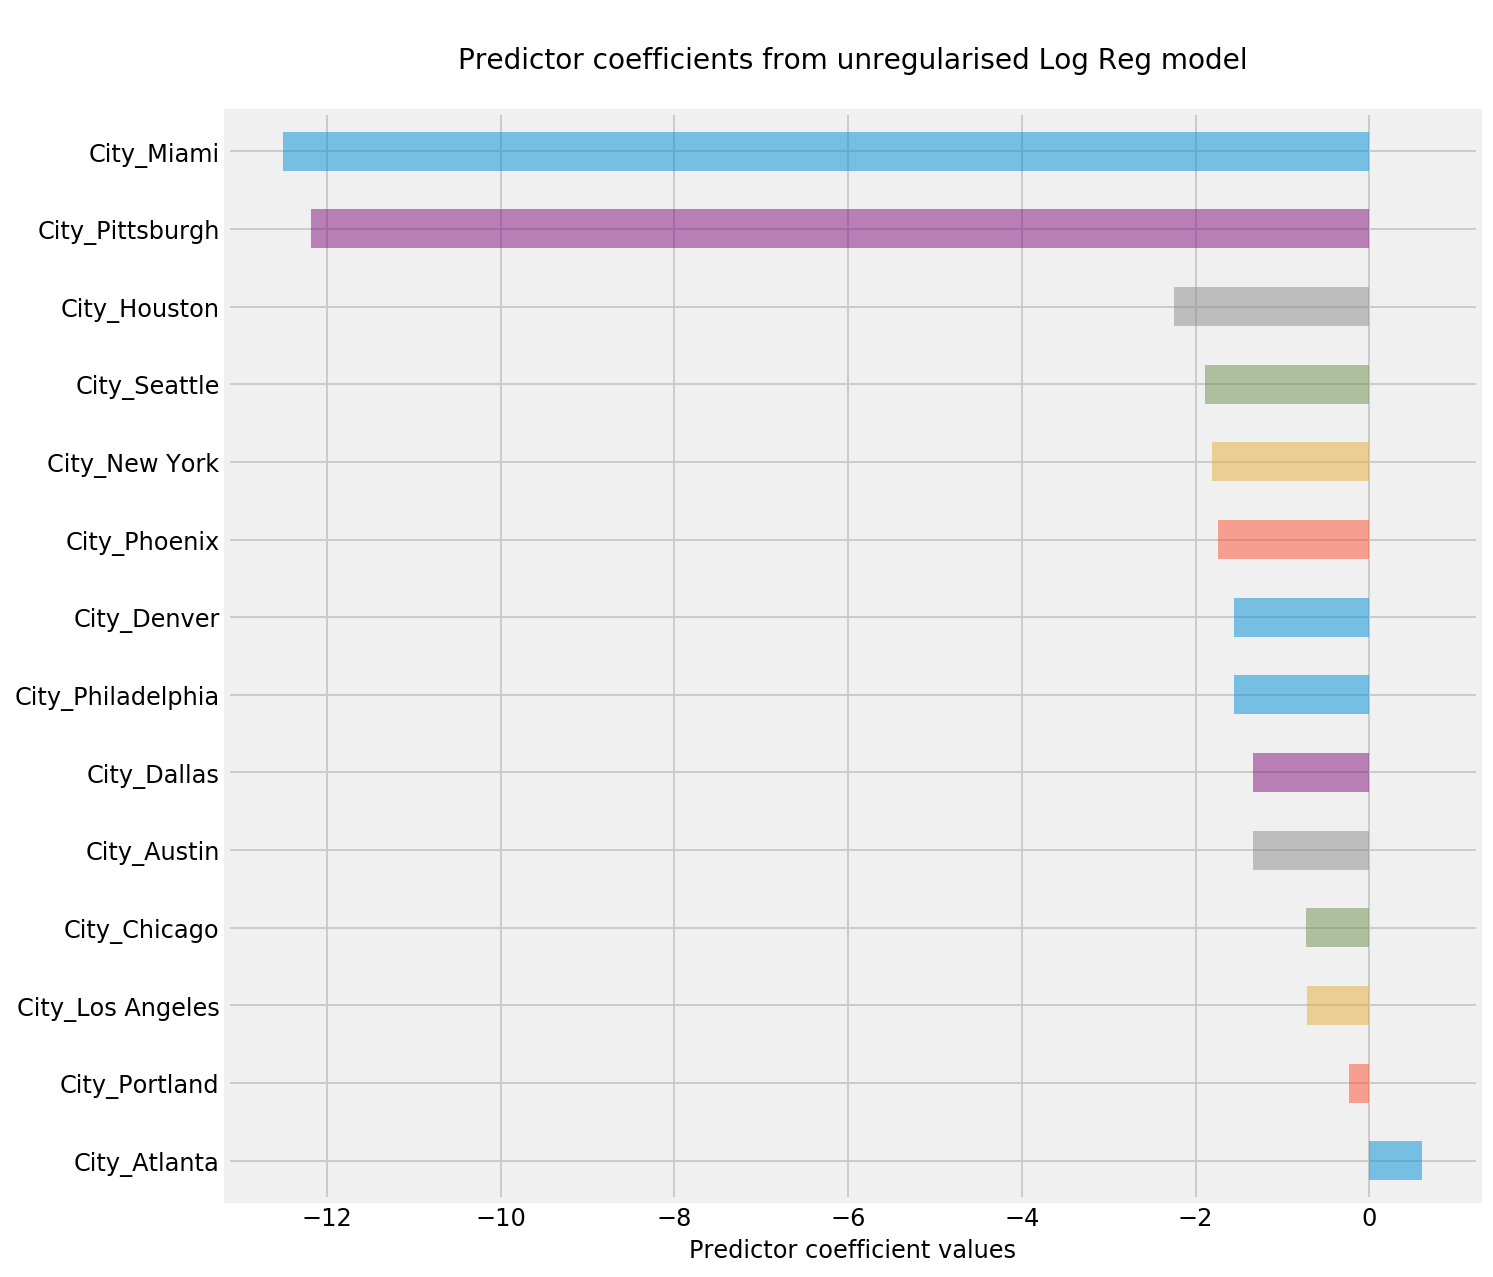

In [48]:
# Plot coefficients from unregularised log reg model above
fig, ax = plt.subplots(figsize=(10,10))
title = '\nPredictor coefficients from unregularised Log Reg model\n'
df_coeff['Coefficients'].plot(kind='barh', ax=ax, alpha=0.5, fontsize=12)
ax.set_yticklabels(df_coeff['city'])
ax.set_xlabel('Predictor coefficient values', fontsize=12)
ax.set_title(title, fontsize=14);

As per the plot above, all coefficients (with the exception of Atlanta) are negative.  This means that the 
log odds of all these cities having a high salary are less than that of the dropped column (i.e. San Francisco).

Where the coefficient is greater than the intercept (1.33500107), the log odds are negative, and for these 
cities the probability of a job having a high salary (within the training data) is less than 0.5.  

The positive coefficient for Atlanta is suprising, given that the probability of a job in Atlanta
having a high salary is less than that for San Francisco (the dropped column).  My theory for this is that 
the representation of Atlanta jobs in the training set may not align well with that in the entire dataset for some 
reason.  With more time, I could investigate this.

We also see large negative coefficients for Miami and Pittsburgh, indicating that the log odds of a high 
salary in these cities is significantly negative, and hence the probability of a high salary in these 
cities is also low (aligned with the ~0 manual probability calculations for these cities and the factorplot above).

In [49]:
# Print the modeled probabilities of each city having a high salary based on the logreg model coefficients
# The calculation must take into account the intercept, but all other predictor variables will be 
# 0 in this case, since the city column has been dumified
list(zip(X_train.columns,list(1/(1+np.exp(-(logreg.intercept_+logreg.coef_[0]))))))

[('City_Atlanta', 0.8750000001819083),
 ('City_Austin', 0.5000000006695041),
 ('City_Chicago', 0.6470588243031284),
 ('City_Dallas', 0.5000000005036406),
 ('City_Denver', 0.4444444450076508),
 ('City_Houston', 0.28571428624954287),
 ('City_Los Angeles', 0.6500000009772567),
 ('City_Miami', 1.4176545035636176e-05),
 ('City_New York', 0.3823529388767935),
 ('City_Philadelphia', 0.4444444454664735),
 ('City_Phoenix', 0.4000000004735159),
 ('City_Pittsburgh', 1.951728349493695e-05),
 ('City_Portland', 0.7500000003244873),
 ('City_Seattle', 0.3636363642016836)]

The figures above are the modeled probabilities of a city having a high salary, using the coefficients from the logreg model.

Let's compare these with the manually calculated probabilities from the section above:

In [50]:
for city in cities:
    print(f'P(High Salary | city = {city}): {round(np.mean(df[df.City == city].High_Salary),2)}')

P(High Salary | city = Dallas): 0.47
P(High Salary | city = Chicago): 0.62
P(High Salary | city = Seattle): 0.63
P(High Salary | city = Los Angeles): 0.59
P(High Salary | city = Pittsburgh): 0.0
P(High Salary | city = Portland): 0.6
P(High Salary | city = Philadelphia): 0.48
P(High Salary | city = Houston): 0.4
P(High Salary | city = New York): 0.41
P(High Salary | city = Atlanta): 0.53
P(High Salary | city = Denver): 0.47
P(High Salary | city = San Francisco): 0.79
P(High Salary | city = Miami): 0.06
P(High Salary | city = Phoenix): 0.4
P(High Salary | city = Austin): 0.56


With the exception of Seattle, Portland, Houston and Atlanta the probability of a city reporting a high salary can be 
reverse-calculated relatively accurately from the coefficients of the logreg model.

I'm not 100% sure why these particular cities would be less accurate than the others - perhaps they aren't as well represented in the training 
data that was used to learn the coefficients?  Again, with more time this could be investigated.

##### Logistic Regression with sklearn (predictors = City and Company Reviews)

For my additional predictor, I'm going to consider the number of company reviews that was specified with each job ad.  I scraped this additional field at the same time as the rest of my Job/Salary data.  My theory is that companies with a large number of reviews, may be larger ... and I'm curious to see if these larger companies pay a higher salary. 


In [51]:
# Quick EDA on Reviews field  
df[['Reviews']].describe()

,Reviews
count,220.000000
mean,1234.645455
std,4820.001272
min,2.000000
25%,16.500000
50%,62.500000
75%,495.000000
max,54889.000000


In [52]:
# Define percentiles from original distribution of number of Reviews.  
# These percentiles will be used for classification of number of company reviews later on.
reviews_25th_perc = df['Reviews'].describe()['25%']
reviews_50th_perc = df['Reviews'].describe()['50%']
reviews_75th_perc = df['Reviews'].describe()['75%']
reviews_IQR = reviews_75th_perc - reviews_25th_perc


In [53]:
# Print number of null values
df.Reviews.isnull().sum()

103

Initial observation of number of company reviews: lot of null values, distribution has a strong positive skew and there appear to be some large outliers.

In [54]:
# Set display parameters for Jupyter.  I haven't set these earliers, as I only want them to apply from now
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [55]:
# Have a quick look at the companies without reviews to see if they are recognisable companies
mask = df.Reviews.isnull()
df.loc[mask, 'Company'].unique()

array(['A+ Consulting', 'Platform by Per Scholas', 'HRK Solutions',
       'The We Are Big Data Scientists Company', 'Camden Kelly',
       'Arbor Diagnostics', 'Hunt Around Solutions',
       'JAMY INTERACTIVE,INC', 'AIC Talent Solutions', 'SymbaSync',
       'All-In Analytics', 'Bulletin of the Atomic Scientists',
       'Fresh Coast Capital', 'Ezra Penland Actuarial Recruitment',
       'Razor', 'CareerMonks', 'Lumity Inc', 'DirectHR',
       'Lighthouse Recruiting', 'SwipeSense', 'Cannabis Retail Company',
       'MMT', 'Curacloud', 'AnswerIQ', 'Neal Analytics',
       'Prisms Consulting Group, LLC', 'Lunar Digital Assets', 'Bradan',
       'Twine', 'Career Strategies, Inc.', 'Employment Service Agency',
       'The Hiring Advisors', 'Nelson', 'Consultative Search Group',
       'Nativo', 'Data Based Solutions Inc.', 'iovation inc',
       'S.C. International', 'ThinkingAhead', 'P&F Solutions',
       'Chatham Group', 'ICON Clinical Research, Inc.',
       'Prism Genomic Medicine I

In [56]:
# The companies with no reviews aren't instantly recognisable.
# For now, set Null values to 0 to assist with examination of distribution of values
df.Reviews.fillna(0, inplace=True)
df.Reviews.isnull().sum()

0

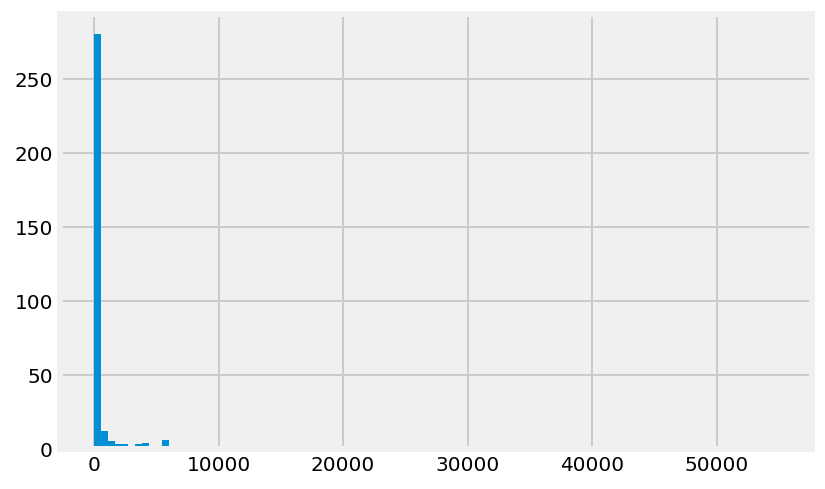

In [57]:
# Plot a very rough histogram snapshot of number of company reviews to get feel for distribution
plt.hist(df.Reviews, bins=100) ;

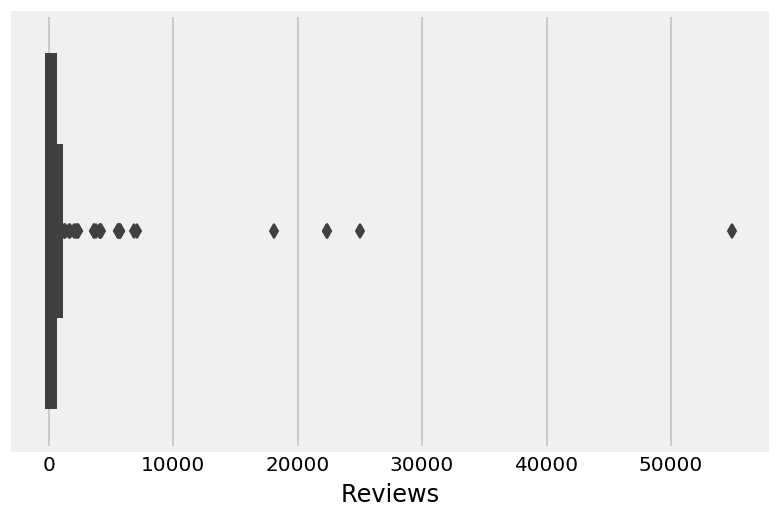

In [58]:
# Plot a very rough boxplot snapshot of number of company reviews to get feel for distribution
sns.boxplot(df.Reviews) ;

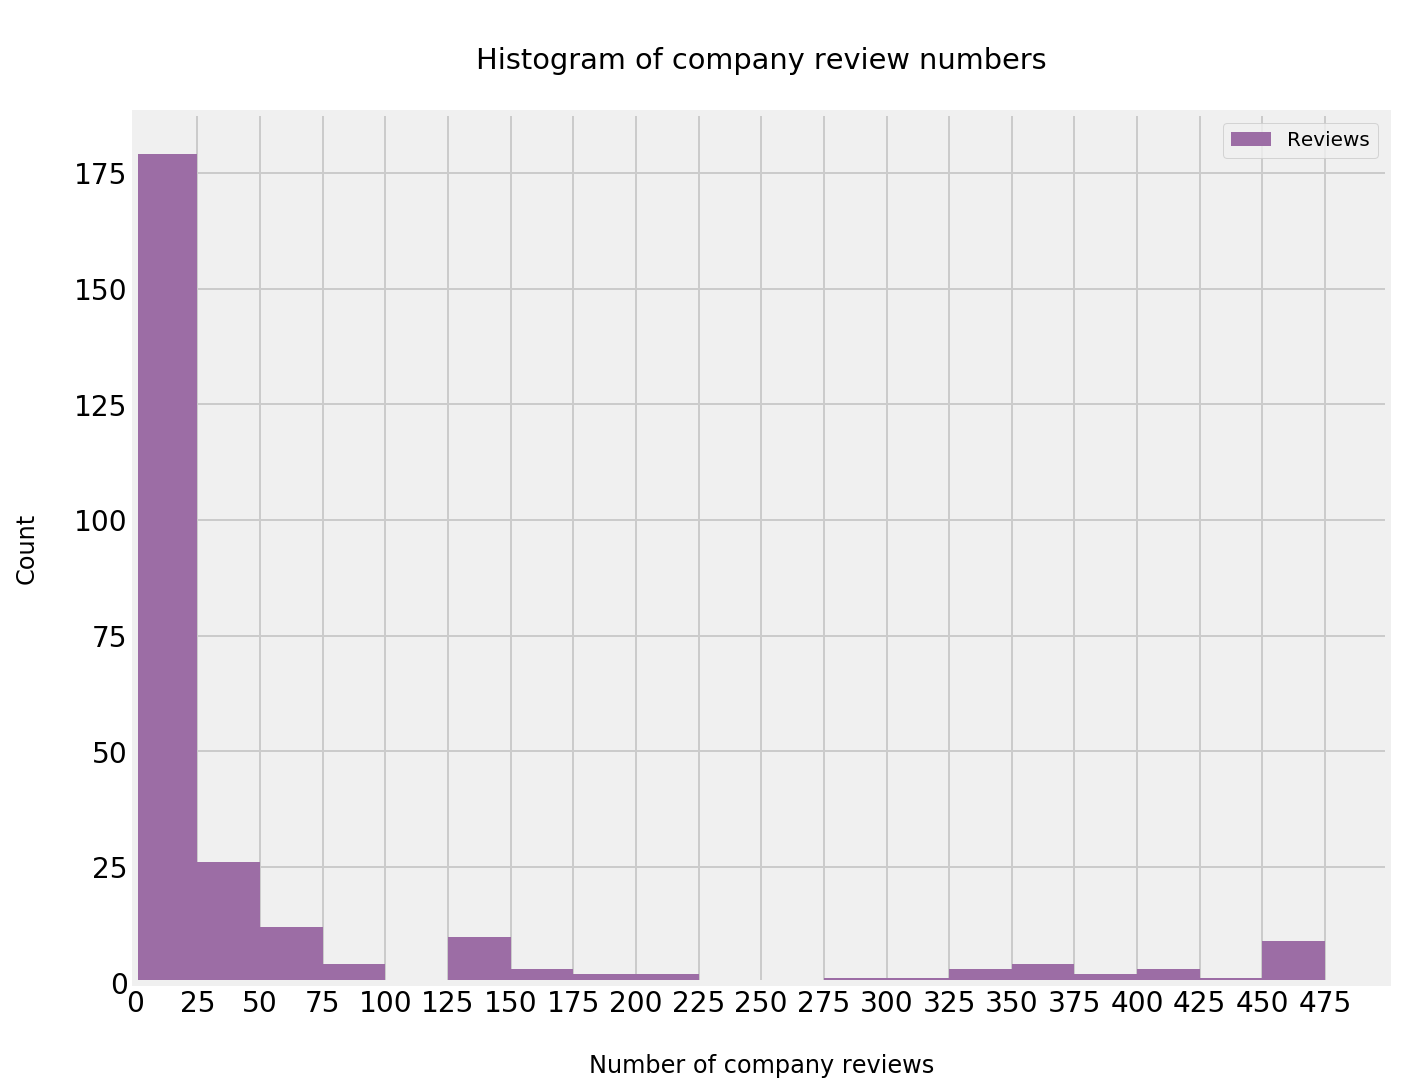

In [59]:
# Plot histogram of Number of Company reviews, focussing on values between 0 and 500
# (i.e. just greater than the 75th percentile)

# Assign paramaters for x and y axis configuration
x_min = 0
x_max = 500
x_bins = list(range(x_min, x_max, 25))

chart_title = '\nHistogram of company review numbers\n'


ax = df.loc[:,['Reviews']].plot.hist(figsize=(10,8), bins=x_bins, 
                                     title = chart_title, fontsize=14, 
                                     color = ['xkcd:dark lilac'])

# Configure x axis display
ax.set_xlim(x_min, x_max) 
ax.set_xticks(x_bins)
ax.set_xlabel('\nNumber of company reviews')
ax.set_ylabel('Count\n') ;

All plots confirm a very strong positive skew of data.  I'll examine a couple of options for managing this.

Option 1: Assign a class to job, based on the number of company reviews: 
        
    - 1 if reviews = 0
    - 2 if reviews less than 25th percentile
    - 3 if reviews between 25-50th percentile
    - 4 if reviews between 50-75th percentile
    - 5 if reviews between 75th percentile + 1.5 * IQR (i.e. within outlier range)
    - 6 if reviews > 75th percentile + 1.5 * IQR (i.e. considered an outlier)

In [60]:
# Option 1:
# Define a function to classify the job based on the number of company reviews, 
# using the original distribution of the field to classify the data 
def classify_review_number(reviews):
    if reviews == 0:
        return 1
    elif reviews < reviews_25th_perc:
        return 2
    elif reviews < reviews_50th_perc:
        return 3
    elif reviews < reviews_75th_perc:
        return 4
    elif reviews < reviews_75th_perc + 1.5 * reviews_IQR:
        return 5
    else:
        return 6
    
# Add column to DF, with classification of jobs based on number of company reviews    
df['Review_Class'] = df['Reviews'].map(classify_review_number)
df.head()

,City,Company,Location,Reviews,Salary,Summary,Title,Indeed_Estimate,High_Salary,Review_Class
0,Dallas,Hitachi Consulting Corporation US,"Dallas, TX",153.0,124000,"The Data Scientist designs, builds and maintai...",Sr Consultant Data Scientist,1,1,4
1,Dallas,7-Eleven,"Irving, TX",7125.0,115000,Work closely with data engineersto ensure the ...,Sr Data Scientist,1,1,6
2,Dallas,Workbridge Associates,"Dallas, TX",36.0,107500,"Experience with data modeling, analysis, progr...",Full-Stack Software Engineer (Predictive Analy...,0,0,3
3,Dallas,A+ Consulting,"Plano, TX",0.0,150000,This is a direct hire position - not contract....,Principal Machine Learning/Nlp Engineer-Architect,0,1,1
4,Dallas,Platform by Per Scholas,"Dallas, TX",0.0,55000,"Java, Oracle DB, Shell Scripting, SDLC and Cod...",Data Scientist/Analyst,0,0,1


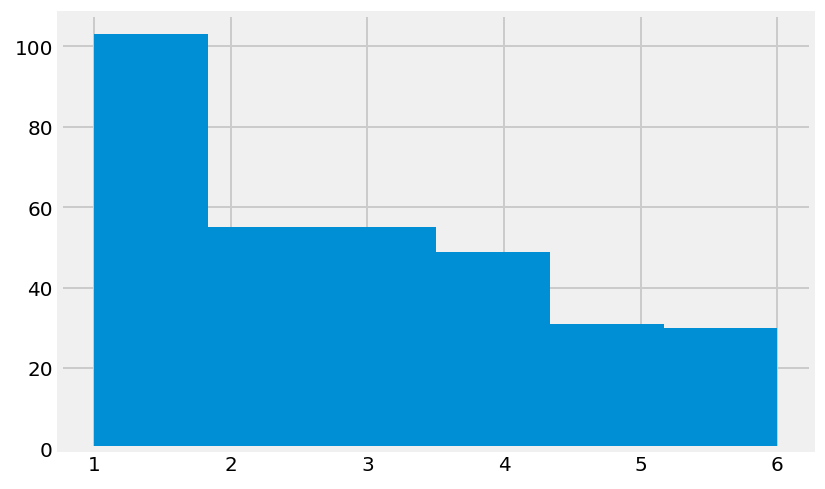

In [61]:
# Rough plot of distribution of Review_Class field
plt.hist(df['Review_Class'], bins = 6);

Option 2: Calculate the log of the number of reviews

In [62]:
# Option 2:
# Define function to return the log of the number of job reviews
# If number of reviews = 0 return 0
def calculate_log_reviews(reviews):
    if reviews == 0:
        return 0
    else:
        return np.log(reviews)

df['Log_Reviews'] = df['Reviews'].map(calculate_log_reviews)
df.head()

,City,Company,Location,Reviews,Salary,Summary,Title,Indeed_Estimate,High_Salary,Review_Class,Log_Reviews
0,Dallas,Hitachi Consulting Corporation US,"Dallas, TX",153.0,124000,"The Data Scientist designs, builds and maintai...",Sr Consultant Data Scientist,1,1,4,5.030438
1,Dallas,7-Eleven,"Irving, TX",7125.0,115000,Work closely with data engineersto ensure the ...,Sr Data Scientist,1,1,6,8.871365
2,Dallas,Workbridge Associates,"Dallas, TX",36.0,107500,"Experience with data modeling, analysis, progr...",Full-Stack Software Engineer (Predictive Analy...,0,0,3,3.583519
3,Dallas,A+ Consulting,"Plano, TX",0.0,150000,This is a direct hire position - not contract....,Principal Machine Learning/Nlp Engineer-Architect,0,1,1,0.000000
4,Dallas,Platform by Per Scholas,"Dallas, TX",0.0,55000,"Java, Oracle DB, Shell Scripting, SDLC and Cod...",Data Scientist/Analyst,0,0,1,0.000000


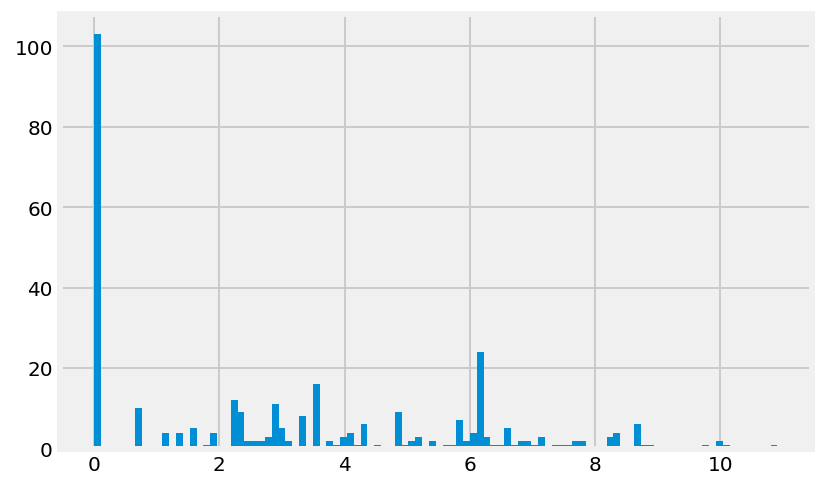

In [63]:
# Rough plot of distribution of Log_Reviews
plt.hist(df['Log_Reviews'], bins=100);

Based on the distributions above, I'm going to use the Review_Class field as my second predictor in the Logistics Regression predictor, rather than the log of the number of the reviews.  

My rationale for this choice is the distribution of the transformed field. 

In [64]:
# Define target array
y = df['High_Salary']

# Define predictor matrix
X2 = df[['City', 'Review_Class']]

# Dumify categorical field (i.e. City) in predictor data
X_dumified2 = pd.get_dummies(X2)

# Drop the dumified City_San Francisco column again
X_dumified2.drop('City_San Francisco', axis=1, inplace=True)

In [65]:
# Create (60:40) train-test and stratify on target to ensure proportionate representation of target classes
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_dumified2, y, test_size=0.4,
                                                        stratify=y, random_state=5)

# Since sklearn's Logistic Regression uses regularisation by default, and the 
# predictors do not have the same scale, these must be standardised
ss = StandardScaler()

# Fit standard scalar on training data and transform both training and test data with it
# Save standardised data as a DF
ss.fit(X_train2)
X_train2_ss = pd.DataFrame(ss.transform(X_train2), columns=X_dumified2.columns)
X_test2_ss = pd.DataFrame(ss.transform(X_test2), columns=X_dumified2.columns)

In [66]:
# Reviews cross validation scores of model on training data.  Shuffle, as data will be ordered.
scores = cross_val_score(LogisticRegression(), X_train2_ss, y_train2, cv=KFold(n_splits=3, shuffle=True))
print('Accuracy scores: ', scores)
print('Mean accuracy score: ', scores.mean())

Accuracy scores:  [0.69230769 0.515625   0.625     ]
Mean accuracy score:  0.6109775641025641


The mean cross validation scores are similar to the model above, implying that the number of company reviews don't add any predicitive capability to the model.

In [67]:
# Fit logistic regression model to training data set
lr2 = LogisticRegression()
lr2.fit(X_train2_ss, y_train2)

# Print accuracy of model for training set
print(f'The accuracy of the model on the training data is: \
{round(lr2.score(X_train2_ss, y_train2),2)}.')

The accuracy of the model on the training data is: 0.66.


Again, the model performs considerbly better on the training data set than the baseline model - but the accuracy score is similar to that achieved in the model above, again implying that the inclusion of the number of company reviews in the model doesn't improve the model's performance.

In [69]:
# Define model predictions based on the test data and print the accuracy score of the model
predictions2 = lr2.predict(X_test2_ss)
# Print accuracy of model for the test set
print(f'The accuracy of the model on the test set is: \
{round(accuracy_score(y_test2, predictions2),2)}.')

The accuracy of the model on the test set is: 0.55.


The model hasn't generalised well to the test data, but the accuracy score is slightly better 
than that achieved with the optimum Logisitic Regression model using the City (only) as the predictor
(i.e. 0.52).

In [70]:
# Use Grid Search to search Logistic Regression hyperparameters to see if model can be improved
# Define logistic regression hyperparameters.  Include very small increments i regularisation strength.
salary_gs_params2 = {'penalty':['l1','l2'],
                    'solver':['liblinear'], 
                    'C':np.logspace(-5, 5, 6000),
                    'fit_intercept':[True, False]}

# Create gridsearch object using LogisticRegression() and the hyperparamater dictionary above
salary_gs2 = GridSearchCV(LogisticRegression(), salary_gs_params2, n_jobs=-1, cv=3, verbose=1)

# Fit gridsearch object on training data
salary_gs2.fit(X_train2_ss, y_train2)

Fitting 3 folds for each of 24000 candidates, totalling 72000 fits


[Parallel(n_jobs=-1)]: Done 2904 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 18504 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 44504 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 72000 out of 72000 | elapsed:   56.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': array([1.00000e-05, 1.00385e-05, ..., 9.96169e+04, 1.00000e+05]), 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [71]:
# Print out best parameters
salary_gs2.best_params_   

{'C': 799.8044766675685,
 'fit_intercept': True,
 'penalty': 'l1',
 'solver': 'liblinear'}

The optimum regularisation parameter sits well within the range provided in the hyperparamater dictionary.  I'm happy with this.

In [72]:
# Print out the best mean cross-validated score
salary_gs2.best_score_ 

0.6373056994818653

In [73]:
# Assign optimum Logistic Regression estimator to best_logreg2
best_logreg2 = salary_gs2.best_estimator_

In [74]:
# Print accuracy score of best log reg model for fit on entire training data set
print(f'The accuracy of the model on the training data is: \
{round(best_logreg2.score(X_train2_ss, y_train2),2)}.')

# Print accuracy score of best log reg model for fit on the test data
print(f'Accuracy score of optimum Logistic Regression model on test data: \
{round(best_logreg2.score(X_test2_ss, y_test2),2)}')

The accuracy of the model on the training data is: 0.66.
Accuracy score of optimum Logistic Regression model on test data: 0.55


Again, the model hasn't generalised well to the test data, but the accuracy score of the model on the test data is higher than that achieved for the optimum logistic regression model without using the number of company reviews as a predictor (i.e. 0.52), suggesting that the number of company reviews add a small amount of predicting capability to the model.  

Note, this accuracy score is the same as that achieved prior to the GridSearch. 

##### Logistic Regression with statsmodel (predictors = City)

I'll now repeat the above two Logistic Regression models with the statsmodel library.

In [75]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import statsmodels.formula.api as smf

In [76]:
df.head()

,City,Company,Location,Reviews,Salary,Summary,Title,Indeed_Estimate,High_Salary,Review_Class,Log_Reviews
0,Dallas,Hitachi Consulting Corporation US,"Dallas, TX",153.0,124000,"The Data Scientist designs, builds and maintai...",Sr Consultant Data Scientist,1,1,4,5.030438
1,Dallas,7-Eleven,"Irving, TX",7125.0,115000,Work closely with data engineersto ensure the ...,Sr Data Scientist,1,1,6,8.871365
2,Dallas,Workbridge Associates,"Dallas, TX",36.0,107500,"Experience with data modeling, analysis, progr...",Full-Stack Software Engineer (Predictive Analy...,0,0,3,3.583519
3,Dallas,A+ Consulting,"Plano, TX",0.0,150000,This is a direct hire position - not contract....,Principal Machine Learning/Nlp Engineer-Architect,0,1,1,0.000000
4,Dallas,Platform by Per Scholas,"Dallas, TX",0.0,55000,"Java, Oracle DB, Shell Scripting, SDLC and Cod...",Data Scientist/Analyst,0,0,1,0.000000


In [77]:
# Fit logistic regression model, using the categorical variable 'City',
# with 'San Francisco' treated as the reference point
sm_city = smf.logit("High_Salary ~ C(City, Treatment(reference='San Francisco'))", 
                    data=df).fit(method='ncg')

# Inspect results
sm_city.summary()

Optimization terminated successfully.
         Current function value: 0.627221
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 22
         Hessian evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            High_Salary   No. Observations:                  323
Model:                          Logit   Df Residuals:                      308
Method:                           MLE   Df Model:                           14
Date:                Mon, 23 Apr 2018   Pseudo R-squ.:                 0.09505
Time:                        22:41:02   Log-Likelihood:                -202.59
converged:                       True   LL-Null:                       -223.87
                                        LLR p-value:                 0.0001007
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         1.3499      0.424      3.183      0.001       0.519       2.181
C(City, Treatment(reference='San Francisco'))[T.Atlanta]         -1.2321      0.645     -1.910      0.056      -2.496       0.032
C(City, Treatment(reference='San Francisco'))[T.Austin]          -1.0986      0.659     -1.668      0.095      -2.390       0.192
C(City, Treatment(reference='San Francisco'))[T.Chicago]         -0.8391      0.560     -1.499      0.134      -1.936       0.258
C(City, Treatment(reference='San Francisco'))[T.Dallas]          -1.4835      0.669     -2.217      0.027      -2.795      -0.172
C(City, Treatment(reference='San Francisco'))[T.Denver]          -1.4677      0.645     -2.276      0.023      -2.732      -0.204
C(City, Treatment(reference='San Francisco'))[T.Houston]         -1.7554      0.589     -2.982      0.003      -2.909      -0.602
C(City, Treatment(reference='San Francisco'))[T.Los Angeles]     -0.9704      0.556     -1.745      0.081      -2.061       0.120
C(City, Treatment(reference='San Francisco'))[T.Miami]           -4.1831      1.113     -3.759      0.000      -6.365      -2.002
C(City, Treatment(reference='San Francisco'))[T.New York]        -1.7272      0.500     -3.454      0.001      -2.707      -0.747
C(City, Treatment(reference='San Francisco'))[T.Philadelphia]    -1.4452      0.609     -2.373      0.018      -2.639      -0.252
C(City, Treatment(reference='San Francisco'))[T.Phoenix]         -1.7554      0.772     -2.273      0.023      -3.269      -0.242
C(City, Treatment(reference='San Francisco'))[T.Pittsburgh]     -11.5275     93.645     -0.123      0.902    -195.069     172.014
C(City, Treatment(reference='San Francisco'))[T.Portland]        -0.9445      1.007     -0.938      0.348      -2.917       1.028
C(City, Treatment(reference='San Francisco'))[T.Seattle]         -0.8109      0.637     -1.273      0.203      -2.060       0.438
=================================================================================================================================
"""

In the instance above, I haven't split the data into a train-test split and have fitted the 
Logistic Regression model to the full data set.

In [78]:
# Print model coefficients
print('Logreg intercept:', sm_city.params[0])
print('Logreg coef(s):', sm_city.params[1:])

Logreg intercept: 1.349923520778688
Logreg coef(s): C(City, Treatment(reference='San Francisco'))[T.Atlanta]         -1.232144
C(City, Treatment(reference='San Francisco'))[T.Austin]          -1.098612
C(City, Treatment(reference='San Francisco'))[T.Chicago]         -0.839101
C(City, Treatment(reference='San Francisco'))[T.Dallas]          -1.483458
C(City, Treatment(reference='San Francisco'))[T.Denver]          -1.467710
C(City, Treatment(reference='San Francisco'))[T.Houston]         -1.755392
C(City, Treatment(reference='San Francisco'))[T.Los Angeles]     -0.970437
C(City, Treatment(reference='San Francisco'))[T.Miami]           -4.183140
C(City, Treatment(reference='San Francisco'))[T.New York]        -1.727221
C(City, Treatment(reference='San Francisco'))[T.Philadelphia]    -1.445237
C(City, Treatment(reference='San Francisco'))[T.Phoenix]         -1.755392
C(City, Treatment(reference='San Francisco'))[T.Pittsburgh]     -11.527468
C(City, Treatment(reference='San Francisco'))[T.

As with the model above developed using sklearn, the coefficients from the model developed using 
statsmodels operate exactly the same way - maximising the likelihood function.

The intercept represents the log odds of a high salary in San Francisco (since this was defined as the feature column).  Note, the intercept is approximately equal to 
the intercept calculatued using sklearn.

The remaining coefficients represent the log odds of a high salary in the associated city, relative to 
San Francisco.  All coefficients are negative, meaning that the log odds of a high salary in these cities 
is less than San Francisco.



In [79]:
# Print probability of a high salary in San Francisco, based on model intercept
print(round(1./(1+np.exp(-(sm_city.params[0]))),2))

0.79


This probability exactly matches the probability calcualted for a high salary in San Francisco above.

In [80]:
# Save model coeffs as a Dataframe and insert city names as indexes
sm_city_coeffs = pd.DataFrame(sm_city.params[1:], columns=['Model Coeffs'])
sm_city_coeffs.index = list(X_dumified.columns)
sm_city_coeffs

,Model Coeffs
City_Atlanta,-1.232144
City_Austin,-1.098612
City_Chicago,-0.839101
City_Dallas,-1.483458
City_Denver,-1.467710
City_Houston,-1.755392
City_Los Angeles,-0.970437
City_Miami,-4.183140
City_New York,-1.727221
City_Philadelphia,-1.445237


In [81]:
# Transform coefficients into probabilities and insert into DF.  Display DF.
sm_city_coeffs['Probability'] = round(1./(1+np.exp(-(sm_city.params.Intercept+
                                               (sm_city_coeffs['Model Coeffs'])))),2)

sm_city_coeffs

,Model Coeffs,Probability
City_Atlanta,-1.232144,0.53
City_Austin,-1.098612,0.56
City_Chicago,-0.839101,0.62
City_Dallas,-1.483458,0.47
City_Denver,-1.467710,0.47
City_Houston,-1.755392,0.40
City_Los Angeles,-0.970437,0.59
City_Miami,-4.183140,0.06
City_New York,-1.727221,0.41
City_Philadelphia,-1.445237,0.48


As can be seen from the probabilities calculated from the model coefficients (displayed above), these
perfectly match the probabilities of a high salary calculated in Section 1.1.1.  In this case,
the probability of high salaries in Atlanta is more accuractely modeled.

I'll now use perform the Logistic Regression using Statsmodel, with a train-test split on the data.

In [82]:
# Create a train-test split on predictor and target data.   
# Assign random state to enable reproducible results
# Stratify on target variable to maintain proportionate representation of target classes

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.4,
                                                    stratify=y, random_state=5)
X_train_sm = X_train_sm.copy()
X_train_sm['High_Salary'] = y_train_sm

In [83]:
X_train_sm.head()

,City,High_Salary
101,Portland,0
132,Houston,1
100,Pittsburgh,0
117,Philadelphia,1
224,Atlanta,1


In [86]:
# Fit logistic regression model, using the categorical variable 'City',
# with 'San Francisco' treated as the reference point
sm_city1 = smf.logit("High_Salary ~ C(City, Treatment(reference='San Francisco'))", 
                    data=X_train_sm).fit(method='ncg', random_state=5)

# Inspect results
sm_city1.summary()

Optimization terminated successfully.
         Current function value: 0.591317
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 24
         Hessian evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            High_Salary   No. Observations:                  193
Model:                          Logit   Df Residuals:                      178
Method:                           MLE   Df Model:                           14
Date:                Mon, 23 Apr 2018   Pseudo R-squ.:                  0.1469
Time:                        22:44:10   Log-Likelihood:                -114.12
converged:                       True   LL-Null:                       -133.77
                                        LLR p-value:                 0.0003276
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         1.3350      0.503      2.656      0.008       0.350       2.320
C(City, Treatment(reference='San Francisco'))[T.Atlanta]          0.6109      1.181      0.517      0.605      -1.704       2.926
C(City, Treatment(reference='San Francisco'))[T.Austin]          -1.3350      0.765     -1.744      0.081      -2.835       0.165
C(City, Treatment(reference='San Francisco'))[T.Chicago]         -0.7289      0.714     -1.020      0.308      -2.129       0.671
C(City, Treatment(reference='San Francisco'))[T.Dallas]          -1.3350      0.959     -1.392      0.164      -3.214       0.544
C(City, Treatment(reference='San Francisco'))[T.Denver]          -1.5581      0.838     -1.859      0.063      -3.201       0.085
C(City, Treatment(reference='San Francisco'))[T.Houston]         -2.2513      0.776     -2.900      0.004      -3.773      -0.730
C(City, Treatment(reference='San Francisco'))[T.Los Angeles]     -0.7160      0.687     -1.042      0.298      -2.063       0.631
C(City, Treatment(reference='San Francisco'))[T.Miami]          -13.6968    161.142     -0.085      0.932    -329.529     302.136
C(City, Treatment(reference='San Francisco'))[T.New York]        -1.8146      0.614     -2.955      0.003      -3.018      -0.611
C(City, Treatment(reference='San Francisco'))[T.Philadelphia]    -1.5581      0.691     -2.255      0.024      -2.913      -0.204
C(City, Treatment(reference='San Francisco'))[T.Phoenix]         -1.7405      1.042     -1.670      0.095      -3.783       0.302
C(City, Treatment(reference='San Francisco'))[T.Pittsburgh]     -12.1927    161.141     -0.076      0.940    -328.023     303.638
C(City, Treatment(reference='San Francisco'))[T.Portland]        -0.2364      1.259     -0.188      0.851      -2.705       2.232
C(City, Treatment(reference='San Francisco'))[T.Seattle]         -1.8946      0.803     -2.358      0.018      -3.469      -0.320
=================================================================================================================================
"""

Note, with the exception of the coefficient for Miami (which has a very slight discrepancy), these coefficients and the intercept 
are 100% aligned with those calculated with SKLearn.

In [87]:
# Use this model on test data to predict High or Low salaries
predictions_sm = 1*(sm_city1.predict(X_test_sm)>0.5).values


In [88]:
# Compare predictions from sklearn and statsmodels
(predictions_sm != predictions).sum()

13

Comparing the predictions between sklearn and statsmodels shows that there are 13 discrepencies. 

There shouldn't be any discrepencies - especially since the coefficients of the 2 models are the same.  I suspect these discrepencies will be due to the different solvers 
used by the 2 models.  The statsmodel here uses the ncg solver, while the Logistic Regression model it's 
being compared to used the default libliner solver.  With some more time, I could re-run these models to verify this.

#### Model taking into account job levels and categories:

- Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value? 
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. 
- Discuss model coefficients or feature importances as applicable.

In [89]:
df.head()

,City,Company,Location,Reviews,Salary,Summary,Title,Indeed_Estimate,High_Salary,Review_Class,Log_Reviews
0,Dallas,Hitachi Consulting Corporation US,"Dallas, TX",153.0,124000,"The Data Scientist designs, builds and maintai...",Sr Consultant Data Scientist,1,1,4,5.030438
1,Dallas,7-Eleven,"Irving, TX",7125.0,115000,Work closely with data engineersto ensure the ...,Sr Data Scientist,1,1,6,8.871365
2,Dallas,Workbridge Associates,"Dallas, TX",36.0,107500,"Experience with data modeling, analysis, progr...",Full-Stack Software Engineer (Predictive Analy...,0,0,3,3.583519
3,Dallas,A+ Consulting,"Plano, TX",0.0,150000,This is a direct hire position - not contract....,Principal Machine Learning/Nlp Engineer-Architect,0,1,1,0.000000
4,Dallas,Platform by Per Scholas,"Dallas, TX",0.0,55000,"Java, Oracle DB, Shell Scripting, SDLC and Cod...",Data Scientist/Analyst,0,0,1,0.000000


In [90]:
# Define copy of df (df_w for analysis of words in job title) and extract the target variable
df_w = df.copy()
y_w = df_w['High_Salary']

I've decided to focus my analysis on keywords within the Job Titles.  I'm going to split my data into training and testing 
data first (to isolate the test data), and will then analyse keywords in the Job Titles within the training data only.

In [91]:
# Split data into training and test sets for analysis of words in Job Title
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(df_w, y_w, test_size=0.4,
                                                            stratify=y_w, random_state=5)

I'm now going to split the training data (only) into 2 DFs: 1 for high salaries and 1 for low salaries.

I'll then use the CountVectoriser class to analyse the most popular words apearing in Job Titles for both High and Low salaries.  This analysis of 'key words' will provide the basis for selecting features based on Job Title (i.e. keywords) to differentiate low and high salaries. 

In [92]:
# Create 2 DFs: 1 for High Salaries and 1 for Low Salaries
X_train_w1 = X_train_w.loc[X_train_w['High_Salary']==1,:]
X_train_w0 = X_train_w.loc[X_train_w['High_Salary']==0,:]

In [93]:
# Import CountVectorizer to facilitate analysis of language used in Job Titles  
from sklearn.feature_extraction.text import CountVectorizer

In [94]:
# Define CountVectoriser object and use the stop_words argument to remove words like "and, the, a"
cvec1 = CountVectorizer(stop_words='english')
cvec0 = CountVectorizer(stop_words='english')

# Fit the count vectorizer on the Job Title data for both High (class 1) and Low (class 0) salary jobs
cvec1.fit(X_train_w1['Title'])
cvec0.fit(X_train_w0['Title'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [95]:
# Print the number of unique words appearing in Job Titles for both High and Low salary jobs
print(f'Number of unique words appearing in High Salary job titles: {len(cvec1.get_feature_names())}')
print(f'Number of unique words appearing in Low Salary job titles: {len(cvec0.get_feature_names())}')

Number of unique words appearing in High Salary job titles: 116
Number of unique words appearing in Low Salary job titles: 171


There are 47% more unique words appearing in the Job Titles of Low salary jobs, than high salary jobs - suggesting more 
'non-standard' naming conventions for lower paid jobs.

In [96]:
# Transform training data (by class) to count the number of unique words appearing in the Job Titles
cvec_mat1 = cvec1.transform(X_train_w1['Title'])
cvec_mat0 = cvec0.transform(X_train_w0['Title'])

In [97]:
# Print percentage occurrence of 25 most frequent words appearing in high salary job titles 
df_cvec1 = pd.DataFrame(cvec_mat1.toarray(), columns=cvec1.get_feature_names())
round(df_cvec1.sum(axis=0).sort_values(ascending=False)[:25] / len(X_train_w1) * 100)

data          54.0
scientist     37.0
engineer      33.0
senior        28.0
software      15.0
machine        8.0
science        8.0
lead           8.0
learning       8.0
research       6.0
analyst        6.0
developer      5.0
sr             5.0
backend        5.0
architect      5.0
modeling       4.0
director       4.0
big            3.0
instructor     3.0
manager        3.0
security       3.0
principal      3.0
level          2.0
immersive      2.0
devops         2.0
dtype: float64

In [98]:
# Print percentage occurrence of 25 most frequent words appearing in low salary job titles 
df_cvec0 = pd.DataFrame(cvec_mat0.toarray(), columns=cvec0.get_feature_names())
round(df_cvec0.sum(axis=0).sort_values(ascending=False)[:25] / len(X_train_w0) * 100)

research         29.0
scientist        27.0
analyst          24.0
data             22.0
engineer         10.0
senior            7.0
manager           7.0
statistician      7.0
technician        7.0
survey            6.0
bureau            5.0
software          4.0
ii                4.0
regional          4.0
health            4.0
environmental     4.0
specialist        4.0
medical           3.0
sciences          3.0
coordinator       3.0
product           3.0
statistical       3.0
associate         3.0
development       3.0
supervisory       3.0
dtype: float64

Note, the analysis above also reveals that there is perhaps some more data cleaning requirements on Job Titles (e.g. standardising instances of sr to Senior, cleaning the 'ii' in the Job Title etc.).  While this is noted, in the interest of time, I won't be cleaning this data here.

Reviewing the data above, I'm looking for words that appear in more than 10% of either high or low salary job titles, and words that also have a notable difference in the percentage of their occurence in high or low salary job titles.  

Based on this, the words I've identified as features to investigate are listed below:
- Data: appears in 54% of high salary job titles, vs 22% of low salary job titles
- Engineer: appears in 33% of high salary job titles, vs 10% of low salary job titles
- Senior: appears in 28% of high salary job titles, vs 7% of low salary job titles
- Software: appears in 15% of high salary job titles, vs 4% of low salary job titles
- Research: appears in 6% of high salary job titles, vs 29% of low salary job titles
- Analyst: appears in 6% of high salary job titles, vs 24% of low salary job titles

In [99]:
# Take copy of DFs to enable insertion of new columns below without warnings
X_train_w = X_train_w.copy()
X_test_w = X_test_w.copy()

In [100]:
# Define list of Job Title keywords
job_title_keywords = ['data', 'engineer', 'senior', 'software', 'research', 'analyst']

# For each Job Title keyword, check if it's in the Job Title, and flag the job with either a 
# 1 or 0 in a keyword-specific column within the training DF to indicate if the word appears 
# in the Job Title or not.  Also updated the test data DF here.
for label in job_title_keywords:
    X_train_w[label+'_keyword'] = X_train_w['Title'].map(lambda x: 1 if label in x.lower() else 0)
    X_test_w[label+'_keyword'] = X_test_w['Title'].map(lambda x: 1 if label in x.lower() else 0)

Note, I'm performing the same loop on the test data, but I'm not reviewing the test data to identify 
specific keywords.  I'm updating the test data here, as these predictors will be used later.  In 'real life', 
I may need to update this DF at a later date (i.e. when the test data is available).

In [101]:
# Check resulting df
X_train_w.head()

,City,Company,Location,Reviews,Salary,Summary,Title,Indeed_Estimate,High_Salary,Review_Class,Log_Reviews,data_keyword,engineer_keyword,senior_keyword,software_keyword,research_keyword,analyst_keyword
101,Portland,Oregon Health & Science University,"Portland, OR",347.0,66916,"Knowledge and proficiency in ERAS, MedHub (res...",Education Manager,0,0,4,5.849325,0,0,0,0,0,0
132,Houston,MD Anderson Cancer Center,"Houston, TX",495.0,122500,Work with research and bioinformatics teams to...,Institute Research Scientist - Translational B...,0,1,5,6.204558,0,0,0,0,1,0
100,Pittsburgh,Oxford Solutions,"Pittsburgh, PA",9.0,102500,Big Data Engineer / Oracle DBA / Data Modeling...,Big Data Engineer,1,0,2,2.197225,1,1,0,0,0,0
117,Philadelphia,Ezra Penland Actuarial Recruitment,"Philadelphia, PA",0.0,150005,"For Position 80800W, a Philadelphia client pla...",Insurance Predictive Modeling Actuary #80800W,0,1,1,0.000000,0,0,0,0,0,0
224,Atlanta,"Next Level Business Services, Inc.","Atlanta, GA",2.0,125000,Knowledge of data collection using query langu...,Data Scientist/Technical Architect,1,1,2,0.693147,1,0,0,0,0,0


In [104]:
# Review how many jobs in the training data have not been flagged with a keyword in their job title
# Note, only review training data as test data should be unseen
X_train_w['keyword_total'] = X_train_w.iloc[:, 11:17].sum(axis=1)
mask = X_train_w['keyword_total'] == 0
print(f'{round(mask.sum() / len(X_train_w) * 100, 2)}% of jobs from the training data have not been \
flagged with a keyword.')


22.8% of jobs from the training data have not been flagged with a keyword.


I'll now take a look at these jobs to see if I can identify additional keywords to differentiate these jobs between high and low salries.

In [105]:
X_train_w.loc[mask, 'Title']

101                                    Education Manager
117        Insurance Predictive Modeling Actuary #80800W
88                       Science Director, Glial Biology
228                                         Statistician
303         Sr. Statistician - Specialist Vii (Job 2239)
37                            Communications Coordinator
221    Supervisory Survey Statistician (Regional Surv...
269                    Manufacturing Technician - Window
121                       Statistical Risk Modeling Lead
287                                  Assistant Scientist
248    Environmental Health & Health Policy Sciences ...
285                                  Associate Scientist
165                           Leader Of Machine Learning
195                  Environmental Compliance Specialist
179                             Strategic Analytics Lead
193    Asthma Coordinator, Bureau Of School Health/Sh...
308                 Educational Instructional Specialist
85     It Technical Recruiter A

Based on review of the Job Titles above, I'm going to add 'scien', 'stat' and 'manager' to my list of Job Title keywords.  I'd originally left 'scientist' out of my list of keywords (even though it appeared in a significant proportion of job titles) as it didn't appear to differentiate High and Low paid jobs signficantly.

In [106]:
# Add both 'scien', 'stat' and 'manager' to my list of Job Title keywords
job_title_keywords = ['scien', 'stat', 'manager']

# Repeat the step above, for these 3 additioanl keywords
for label in job_title_keywords:
    X_train_w[label+'_keyword'] = X_train_w['Title'].map(lambda x: 1 if label in x.lower() else 0)
    X_test_w[label+'_keyword'] = X_test_w['Title'].map(lambda x: 1 if label in x.lower() else 0)

In [107]:
# Drop previous keyword_total column
X_train_w.drop('keyword_total', axis=1, inplace=True)

In [108]:
X_train_w.head()

,City,Company,Location,Reviews,Salary,Summary,Title,Indeed_Estimate,High_Salary,Review_Class,Log_Reviews,data_keyword,engineer_keyword,senior_keyword,software_keyword,research_keyword,analyst_keyword,scien_keyword,stat_keyword,manager_keyword
101,Portland,Oregon Health & Science University,"Portland, OR",347.0,66916,"Knowledge and proficiency in ERAS, MedHub (res...",Education Manager,0,0,4,5.849325,0,0,0,0,0,0,0,0,1
132,Houston,MD Anderson Cancer Center,"Houston, TX",495.0,122500,Work with research and bioinformatics teams to...,Institute Research Scientist - Translational B...,0,1,5,6.204558,0,0,0,0,1,0,1,0,0
100,Pittsburgh,Oxford Solutions,"Pittsburgh, PA",9.0,102500,Big Data Engineer / Oracle DBA / Data Modeling...,Big Data Engineer,1,0,2,2.197225,1,1,0,0,0,0,0,0,0
117,Philadelphia,Ezra Penland Actuarial Recruitment,"Philadelphia, PA",0.0,150005,"For Position 80800W, a Philadelphia client pla...",Insurance Predictive Modeling Actuary #80800W,0,1,1,0.000000,0,0,0,0,0,0,0,0,0
224,Atlanta,"Next Level Business Services, Inc.","Atlanta, GA",2.0,125000,Knowledge of data collection using query langu...,Data Scientist/Technical Architect,1,1,2,0.693147,1,0,0,0,0,0,1,0,0


In [109]:
# Review again how many jobs in the training data have not been flagged with a keyword in their job title
# Note, only reviewing the training data as test data should be unseen
X_train_w['keyword_total'] = X_train_w.iloc[:, 11:20].sum(axis=1)
mask = X_train_w['keyword_total'] == 0
print(f'{round(mask.sum() / len(X_train_w) * 100, 2)}% of jobs from the training data have not been \
flagged with a keyword.')

11.92% of jobs from the training data have not been flagged with a keyword.


I'm comfortable with this percentage and will now model the data based on this.

In [110]:
# Define list of columns to drop from the training and test data for the predictor matrices
drop_columns = ['Company', 'Location', 'Reviews', 'Salary', 'Summary', 'Title', 'Indeed_Estimate',
                'High_Salary', 'Log_Reviews', 'keyword_total']

X_train_wp = X_train_w.drop(drop_columns, axis=1)
X_test_wp = X_test_w.drop(drop_columns[:-1], axis=1)   # The predictor test set doesn't contain the keyword_total column

In [111]:
# Verify size of precitor matrices and target arrays before modeling
print(X_train_wp.shape)
print(X_test_wp.shape)
print(y_train_w.shape)
print(y_test_w.shape)

(193, 11)
(130, 11)
(193,)
(130,)


In [112]:
# Verify that all cities are represented in the train and test predictor matrices before dumifying
X_train_wp['City'].value_counts()

New York         34
San Francisco    24
Los Angeles      20
Philadelphia     18
Chicago          17
Houston          14
Austin           12
Seattle          11
Miami             9
Denver            9
Atlanta           8
Dallas            6
Phoenix           5
Portland          4
Pittsburgh        2
Name: City, dtype: int64

In [113]:
X_test_wp['City'].value_counts()

New York         25
Chicago          15
Los Angeles      12
Houston          11
San Francisco    10
Miami             9
Atlanta           9
Dallas            9
Seattle           8
Denver            8
Phoenix           5
Austin            4
Philadelphia      3
Portland          1
Pittsburgh        1
Name: City, dtype: int64

In [114]:
# Dumify train and test data separately, dropping the San Francisco column in both
X_train_wp = pd.get_dummies(X_train_wp)
X_train_wp.drop('City_San Francisco', axis=1, inplace=True)
X_test_wp = pd.get_dummies(X_test_wp)
X_test_wp.drop('City_San Francisco', axis=1, inplace=True)

In [115]:
# Standardise train and test predictor matrices with standard scalar fitted to to the training data
ss = StandardScaler()
ss.fit(X_train_wp)

X_train_wp_ss = ss.transform(X_train_wp)
X_test_wp_ss = ss.transform(X_test_wp)

In [116]:
# Confirm that the mean and standard deviation of each column in the training data are 0 and 1 respectively
pd.DataFrame(X_train_wp_ss, columns=X_train_wp.columns).describe()

,Review_Class,data_keyword,engineer_keyword,senior_keyword,software_keyword,research_keyword,analyst_keyword,scien_keyword,stat_keyword,manager_keyword,City_Atlanta,City_Austin,City_Chicago,City_Dallas,City_Denver,City_Houston,City_Los Angeles,City_Miami,City_New York,City_Philadelphia,City_Phoenix,City_Pittsburgh,City_Portland,City_Seattle
count,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02
mean,-1.210891e-16,1.185005e-16,3.681569e-17,5.752451e-17,5.752451e-19,1.196510e-16,-3.595282e-17,-1.668211e-16,-4.889583e-17,-2.349876e-16,-1.567543e-16,-3.911667e-17,5.867500e-17,-8.858774e-17,5.119681e-17,-1.179252e-17,-4.889583e-17,5.177206e-18,8.283529e-17,6.155122e-17,-3.106323e-17,-1.471189e-16,-7.161801e-17,-2.223322e-16
std,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00
min,-1.042341e+00,-7.713892e-01,-5.354126e-01,-4.624246e-01,-3.304473e-01,-4.541476e-01,-4.119429e-01,-7.972410e-01,-2.796646e-01,-2.337623e-01,-2.079501e-01,-2.574846e-01,-3.107908e-01,-1.791244e-01,-2.211629e-01,-2.796646e-01,-3.400102e-01,-2.211629e-01,-4.624246e-01,-3.207135e-01,-1.630820e-01,-1.023289e-01,-1.454786e-01,-2.458446e-01
25%,-1.042341e+00,-7.713892e-01,-5.354126e-01,-4.624246e-01,-3.304473e-01,-4.541476e-01,-4.119429e-01,-7.972410e-01,-2.796646e-01,-2.337623e-01,-2.079501e-01,-2.574846e-01,-3.107908e-01,-1.791244e-01,-2.211629e-01,-2.796646e-01,-3.400102e-01,-2.211629e-01,-4.624246e-01,-3.207135e-01,-1.630820e-01,-1.023289e-01,-1.454786e-01,-2.458446e-01
50%,-4.233510e-01,-7.713892e-01,-5.354126e-01,-4.624246e-01,-3.304473e-01,-4.541476e-01,-4.119429e-01,-7.972410e-01,-2.796646e-01,-2.337623e-01,-2.079501e-01,-2.574846e-01,-3.107908e-01,-1.791244e-01,-2.211629e-01,-2.796646e-01,-3.400102e-01,-2.211629e-01,-4.624246e-01,-3.207135e-01,-1.630820e-01,-1.023289e-01,-1.454786e-01,-2.458446e-01
75%,8.146300e-01,1.296362e+00,-5.354126e-01,-4.624246e-01,-3.304473e-01,-4.541476e-01,-4.119429e-01,1.254326e+00,-2.796646e-01,-2.337623e-01,-2.079501e-01,-2.574846e-01,-3.107908e-01,-1.791244e-01,-2.211629e-01,-2.796646e-01,-3.400102e-01,-2.211629e-01,-4.624246e-01,-3.207135e-01,-1.630820e-01,-1.023289e-01,-1.454786e-01,-2.458446e-01
max,2.052611e+00,1.296362e+00,1.867718e+00,2.162515e+00,3.026201e+00,2.201928e+00,2.427521e+00,1.254326e+00,3.575712e+00,4.277850e+00,4.808846e+00,3.883727e+00,3.217599e+00,5.582711e+00,4.521553e+00,3.575712e+00,2.941088e+00,4.521553e+00,2.162515e+00,3.118048e+00,6.131884e+00,9.772410e+00,6.873864e+00,4.067610e+00


The mean and standard deviations of all columns are 0 and 1 respectively. 

I'm now ready to model the data.

In [128]:
# Reviews cross validation scores of model on training data.  Shuffle, as data will be ordered.
scores = cross_val_score(LogisticRegression(), X_train_wp_ss, y_train_w, cv=KFold(n_splits=3, shuffle=True))
print('Accuracy scores: ', scores)
print('Mean accuracy score: ', scores.mean())

Accuracy scores:  [0.63076923 0.65625    0.734375  ]
Mean accuracy score:  0.6737980769230769


Cross val accuracy scores look OK, and are an improvement on those that did not use keywords in the job title to predict high and low salaries.

In [129]:
# Fit logistic regression model to training data set
lr3 = LogisticRegression()
lr3.fit(X_train_wp_ss, y_train_w)

# Print accuracy of model for training set
print(f'The accuracy of the model on the training data is: \
{round(lr3.score(X_train_wp_ss, y_train_w),2)}.')

The accuracy of the model on the training data is: 0.78.


This is a significant improvement on the accuracy from the previous models.

In [131]:
# Define model predictions based on the test data and print the accuracy score of the model
predictions3 = lr3.predict(X_test_wp_ss)
# Print accuracy of model for the test set
print(f'The accuracy of the model on the test set is: \
{round(accuracy_score(y_test_w, predictions3),2)}.')

The accuracy of the model on the test set is: 0.74.


This is a significant improvement on the accurcy score from previous models.  The highest accuracy scores I'd achieved on the test data previously was 0.55.  This is an improvement in accuracy of 35%. 

Let's see if we can improve on this further with a GridSearch.  Again, I'm choosing a very small increments in regularisation strength to try to catch any 'peaks'.

In [132]:
# Define gridsearch hyperparameters, instantiate GridSearch object and fit to training data 
 
salary_gs_params2 = {'penalty':['l1','l2'],
                    'solver':['liblinear'], 
                    'C':np.logspace(-5, 5, 6000),
                    'fit_intercept':[True, False]}

salary_gs2 = GridSearchCV(LogisticRegression(), salary_gs_params2, 
                         n_jobs=-1, cv=3, verbose=1)

salary_gs2.fit(X_train_wp_ss, y_train_w)

Fitting 3 folds for each of 24000 candidates, totalling 72000 fits


[Parallel(n_jobs=-1)]: Done 2784 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 17784 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 42784 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 72000 out of 72000 | elapsed:   50.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': array([1.00000e-05, 1.00385e-05, ..., 9.96169e+04, 1.00000e+05]), 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [133]:
# Inspect best params
salary_gs2.best_params_ 

{'C': 0.008753001969168846,
 'fit_intercept': False,
 'penalty': 'l2',
 'solver': 'liblinear'}

The optimum regularisation strength is well within the hyperparameter range.  I'm happy with this.

In [134]:
# Print out best mean cross validated score
salary_gs2.best_score_  

0.7409326424870466

This is an improvement on the mean cross validation accuracy score prior to the GridSearch, which was 0.68.

In [135]:
# Assign optimum Logisitc Regression estimator to best_logreg3
best_logreg2 = salary_gs2.best_estimator_

# Print accuracy score of best log reg model for fit on entire training data set
print(f'The accuracy of the model on the training data is: \
{round(best_logreg2.score(X_train_wp_ss, y_train_w),2)}.')

# Print accuracy score of best log reg model for fit on the test data
print(f'Accuracy score of optimum Logistic Regression model on test data: \
{round(best_logreg2.score(X_test_wp_ss, y_test_w),2)}')

The accuracy of the model on the training data is: 0.78.
Accuracy score of optimum Logistic Regression model on test data: 0.76


With the optimum Logistic Regression model identified in the GridSearch, 
the accuracy score on the training data has remained the same but it's improved from 0.74 to 0.76 on the test 
data, suggesting that the previous model may have been overfitted to the training data.  

The optimum logistic regression model is generalising better to the test data than the previous model.

In [136]:
# Define predictions based on optimum Logistic Regression model
predictions_w = best_logreg2.predict(X_test_wp_ss)

In [137]:
# Cross check accuracy score calcuated using sklearn with manual calculation
print(f'Manually calculated accuracy score: {round((predictions_w == y_test_w).sum()/len(y_test_w),2)}')

Manually calculated accuracy score: 0.76


The cross check calculation of the accuracy score is aligned.

In [138]:
# Display confusion matrix
confusion = confusion_matrix(y_test_w, predictions_w)
pd.DataFrame(confusion, columns=['Predicted Low Salary', 'Predicted High Salary'], 
             index=['Actual Low Salary', 'Actual High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,45,19
Actual High Salary,12,54


With the inclusion of keywords from the job titles, reviewing the confusion matrix above reveals that the model is now performing better in the prediction of high 
salaries than lower salaries.  This is a reversal from the model that was using City as a predictor only.

Given that lower paid jobs contained 47% more unique words in their job titles than higher paid roles, my theory is that there is a stronger signal generated 
from role titles for higher paid jobs than lower paid jobs (which contain more non-standard role titles/noise), hence this model is now performing better at predicting higher paid jobs.



In [139]:
# Cross check accuracy score with data in confusion matrix
print(f'Accuracy score calculated from confusion matrix: \
{round((confusion[0][0] + confusion[1][1])/confusion.sum(),2)}')

Accuracy score calculated from confusion matrix: 0.76


Again, this calculation cross checks with the accuracy score calculated by sklearn.

In [140]:
# Print recall score / true positive rate (tp / tp + fn)
print(f'Recall score/true positive rate is: {round(recall_score(y_test_w, predictions_w),2)}')

# Print specicifity / true negative rate (tn / tn + fp)
print(f'Specicity score/true negative rate is: {round(recall_score(y_test_w==0, predictions_w==0),2)}')

# Print false positive rate (fp / tn + fp)
print(f'False positive rate is: {round(confusion[0][1] / (confusion[0][0] + confusion[0][1]),2)}')


Recall score/true positive rate is: 0.82
Specicity score/true negative rate is: 0.7
False positive rate is: 0.3


In [141]:
# Print classification report 
print(classification_report(y_test_w, predictions_w))

             precision    recall  f1-score   support

          0       0.79      0.70      0.74        64
          1       0.74      0.82      0.78        66

avg / total       0.76      0.76      0.76       130



Reviewing the classification report, we see that we had 64 and 66 salaries classified as low and high respectively in the test, target data.


The precision of this model to correctly predict a High Salary is 0.74 (i.e. in 74% of cases where the model predicted a high salary, the actual salary was classified as High).  In 79% of cases where the model predicted a low salary, the actual salary was classified as low.  We can see from the confusion matrix that the model predicts low salaries less often, but when it does it predicts a higher percentage of low classifications correctly.


According to the recall scores, out of all the salaries classified as High in the test data, the model correctly predicted 82% of these vs correctly predicting 70% (i.e. specicifity) of low salaries - reinforcing the observation above that the model is performing better in predicting high salaries vs low salaries.  Having said this, as per the point above, the model demonstrates less precision in predicting High salaries.

The overall performance of this model would need to be considered in the context of what's most important to 'get right' in this particular instance.


#### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 


- Use cross-validation to evaluate your models. 
- Evaluate the accuracy, AUC, precision and recall of the models. 
- Plot the ROC curve for at least one of your models.

# Answer

If my boss would prefer to tell a client incorrectly that a job will get a lower salary vs incorrectly telling them 
they would get a higher salary, this means he/she is willing to increase the false negatives within this model
at the expense of the overall accuracy of the model. 

In [142]:
# Calculate probability of predicting high and low salaries using the optimum log reg model above
# Store probabilities in a DF
predictions_w_prob = best_logreg2.predict_proba(X_test_wp_ss)
predictions_w_prob = pd.DataFrame(predictions_w_prob, columns=['Class_0_prob','Class_1_prob'])
predictions_w_prob.head(15)

,Class_0_prob,Class_1_prob
0,0.369065,0.630935
1,0.482860,0.517140
2,0.521719,0.478281
3,0.815912,0.184088
4,0.302474,0.697526
5,0.475193,0.524807
6,0.465365,0.534635
7,0.713965,0.286035
8,0.517733,0.482267
9,0.521717,0.478283


In [143]:
# Show first 15 entries of predictions as a DF to enable easy comparison of predictions with probabilities above
pd.DataFrame(predictions_w, columns=['Class_pred']).head(15)

,Class_pred
0,1
1,1
2,0
3,0
4,1
5,1
6,1
7,0
8,0
9,0


By comparing the predicted class (Class_pred) with the predicted probabilities of each class (Class_0_prob 
and Class_1_prob) we can see that a threshold of 0.5 probability is being used to differentiate between the 
predicted classification of salaries as either high or low.  This means that if the predicted probability
of a high class is greater than 0.5, the predicted classification for that salary will also be high.


If my boss would prefer to incorrectly predicting low salaries rather than high salaries, then the model 
must use a probability higher than 0.5 to classify salaries as either high or low.  If we increase this probability 
to 0.6 for example, this means that a predicted probability of greater than 0.6 is required for 
the model to predict the classification of a salary as High.

In [144]:
# Add column to predictions_w_prob DF where probability must be greater than 0.6 to predict 
# class 1 (i.e. High salary)
predictions_w_prob['Pred_Class_thresh60'] = [1 if x > 0.60 else 0 
                                             for x in predictions_w_prob.Class_1_prob.values]
predictions_w_prob.head(15)

,Class_0_prob,Class_1_prob,Pred_Class_thresh60
0,0.369065,0.630935,1
1,0.482860,0.517140,0
2,0.521719,0.478281,0
3,0.815912,0.184088,0
4,0.302474,0.697526,1
5,0.475193,0.524807,0
6,0.465365,0.534635,0
7,0.713965,0.286035,0
8,0.517733,0.482267,0
9,0.521717,0.478283,0


In [145]:
# Define predictions for threshold probability = 0.6
predictions_w_60 = predictions_w_prob['Pred_Class_thresh60'].values

In [146]:
# Print change in number of salaries predicted as High or Low as a result of changing probability 
# threshold used by the model for differerntiating between High and Low salaries

# Define variables to store number of predictions classified as high for 0.5 and 0.6 probabilities
high_50 = predictions_w.sum()
high_60 = predictions_w_60.sum()
num_pred = len(predictions_w)

print(f'With the probability threshold for differentiating between High and Low \
salaries increased from 0.5 to 0.6, the number of salaries predicted by the model as \
being: \n \t - high, has decreased from {high_50} to {high_60}\
\n \t - low, has increased from {num_pred - high_50} to {num_pred - high_60}.')


With the probability threshold for differentiating between High and Low salaries increased from 0.5 to 0.6, the number of salaries predicted by the model as being: 
 	 - high, has decreased from 73 to 29
 	 - low, has increased from 57 to 101.


I'll now compare the confusion matrices for the model based on the 0.5 and 0.6 probability thresholds.

In [147]:
# Display confusion matrix for original model predictions (i.e. probability threshold = 0.5)
confusion_50 = confusion_matrix(y_test_w, predictions_w)
pd.DataFrame(confusion_50, columns=['Predicted Low Salary', 'Predicted High Salary'], 
             index=['Actual Low Salary', 'Actual High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,45,19
Actual High Salary,12,54


In [148]:
# Display confusion matrix for revised model predictions (i.e. probability threshold = 0.6)
confusion_60 = confusion_matrix(y_test_w, predictions_w_60)
pd.DataFrame(confusion_60, columns=['Predicted Low Salary', 'Predicted High Salary'], 
             index=['Actual Low Salary', 'Actual High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,58,6
Actual High Salary,43,23


The numbers of salaries predicted as high and low as depicted in the confusion matrices aligns with the manual calculations above. There is a 
significant increase in the number of salaries predicted as low, as the probability threshold fo classifying salaries as high has increased.

I'll now calculate the false positive rate (fpr) of both models.  The fpr measures out of all the times the true label was negative, the predicted label was positive.

In [149]:
# Calculate false positive rates (fp / (tn + fp)) for both probability thresholds 
fpr_50 = round(confusion_50[0][1] / (confusion_50[0][1] + confusion_50[0][0]),2)
fpr_60 = round(confusion_60[0][1] / (confusion_60[0][1] + confusion_60[0][0]),2)

print(f'With the increase in the probability threshold from 0.5 to 0.6, the false \
positive rate has decreased from {fpr_50} to {fpr_60}.')


With the increase in the probability threshold from 0.5 to 0.6, the false positive rate has decreased from 0.3 to 0.09.


This was the desired outcome of my boss in this case i.e. to incorrectly predict high salaries less often.

I'll now calculate the specificty / true negative rate (tnr) of both models.  The tnr measures out of all the times the true label was negative, the predicted label was also negative.  I'd expect this to increase in this case, as the revised model is predicting low salaries with a higher probability threshold of being low.

In [150]:
# Calculate specicifity / true negative rate ((tn / tn + fp)) for both probability thresholds
tnr_50 = round(confusion_50[0][0] / (confusion_50[0][0] + confusion_50[0][1]),2)
tnr_60 = round(confusion_60[0][0] / (confusion_60[0][0] + confusion_60[0][1]),2)

print(f'With the increase in the probability threshold from 0.5 to 0.6, the true \
negative rate has increased from {tnr_50} to {tnr_60}.')

With the increase in the probability threshold from 0.5 to 0.6, the true negative rate has increased from 0.7 to 0.91.


This increase in the true negative rate means that out of all the times the true label was negative, the predicted label was also negative in 91% of cases for the model with the higher probability threshold, vs 70% of cases for the model with the lower probability threshold.

In [151]:
# Calculate model accuracy for both probability thresholds
accuracy_50 = round(accuracy_score(y_test_w, predictions_w),2)
accuracy_60 = round(accuracy_score(y_test_w, predictions_w_60),2)

print(f'With the increase in the probability threshold from 0.5 to 0.6, the model accuracy \
has decreased from {accuracy_50} to {accuracy_60}.')

With the increase in the probability threshold from 0.5 to 0.6, the model accuracy has decreased from 0.76 to 0.62.


The overall accuracy of the model has descreased because misclassifications have increased.  Why have misclassifications increased?  
Becase we are incorrectly classifying more salaries as low as a result of the increased probability threshold. The model is predicting less false positives, but more false negatives. 

I'll now confirm this by calculating the change in false negative rates (fnr) between the 2 models.  
The false negative rate measures out of all the times the true label was positive, the predicted label was negative.

In [152]:
# Calculate false negative rates ((fn / (tp + fn)) for both probability thresholds
fnr_50 = round(confusion_50[1][0] / (confusion_50[1][0] + confusion_50[1][1]),2)
fnr_60 = round(confusion_60[1][0] / (confusion_60[1][0] + confusion_60[1][1]),2)

print(f'With the increase in the probability threshold from 0.5 to 0.6, the model\'s false \
negative rate has increased from {fnr_50} to {fnr_60}.')

With the increase in the probability threshold from 0.5 to 0.6, the model's false negative rate has increased from 0.18 to 0.65.


Based on the calculations above, we can see that the rate of false negatives (i.e. predicting low salaries when the actual salay is high) has increased significantly.

This is aligned with the request of 'my boss' in this case.

Finally, I'll calculate the precision (prec) score of the model.  The precision measures out of all the times the classifier predicted a positive label, the true label was also positive.  Given that the revised model is using a higher probability threshold to classify slaries as high, 
I'd expect this model to have greater precision in predicting high salaries.

In [153]:
# Print the precision scores for both models
prec_50 = round(precision_score(y_test_w, predictions_w),2)
prec_60 = round(precision_score(y_test_w, predictions_w_60),2)

print(f'With the increase in the probability threshold from 0.5 to 0.6, the model\'s \
precision score has increased from {prec_50} to {prec_60}.')

With the increase in the probability threshold from 0.5 to 0.6, the model's precision score has increased from 0.74 to 0.79.


The model has a greater precision in predicting high salaries, which is aligned with my boss' request.

In [154]:
# Print the clasification report for both models
print('\nClassification report for model using 0.5 probability threshold...')
print(classification_report(y_test_w, predictions_w))
print('\n\nClassification report for model using 0.6 probability threshold...')
print(classification_report(y_test_w, predictions_w_60))


Classification report for model using 0.5 probability threshold...
             precision    recall  f1-score   support

          0       0.79      0.70      0.74        64
          1       0.74      0.82      0.78        66

avg / total       0.76      0.76      0.76       130



Classification report for model using 0.6 probability threshold...
             precision    recall  f1-score   support

          0       0.57      0.91      0.70        64
          1       0.79      0.35      0.48        66

avg / total       0.69      0.62      0.59       130



As can be seen from the classification reports above:
    - the precision score for predicting high salaries has increased from 0.74 to 0.79, as the probability threshold has increased (in line with the calculations above)
    - the precision score for predicting low salaries has decreased signficantly from 0.79 to 0.57, because the higher probability threshold results in the model misclassifying a greater number of salaries as low
    - the recall score for predicting high salaries has decreased significantly from 0.82 to 0.35.  Note, this is equivalent to the increase in false negative rate calculated above.  This decrease reflects the fact that we're 'catching less' high salaries.
    - the recall score for predicting low salaries has increased significantly from 0.7 to 0.91 as a result of being 'over conservative' in predicting low salaries as a result of the higher probability threshold for the 2nd model.

Plot ROC curve for best_logreg2 model.  This was the model that used City, Reviews and Job Title keywords as predictors 
and achieved accuracy scores of 0.78 and 0.76 on my training and test data respectively.


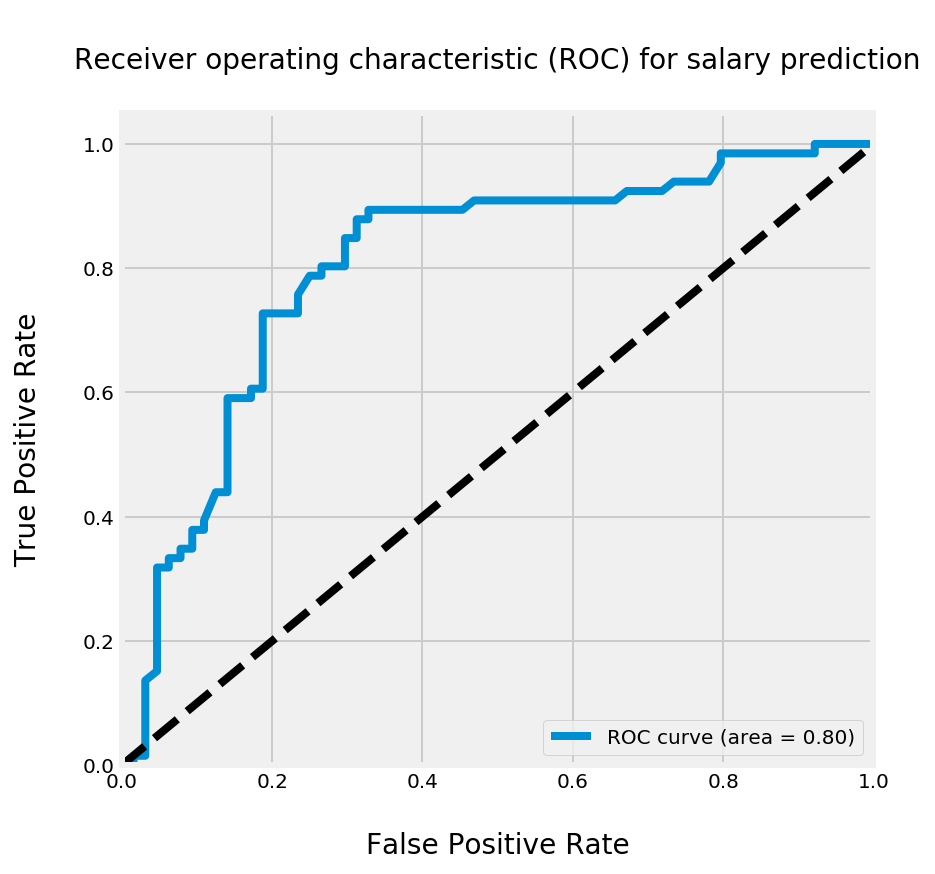

In [156]:
# For class 1, find the area under the curve
fpr, tpr, threshold = roc_curve(y_test_w, predictions_w_prob['Class_1_prob'])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (high salary)
plt.figure(figsize=[6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('\nFalse Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate\n', fontsize=14)
plt.title('\nReceiver operating characteristic (ROC) for salary prediction\n', fontsize=14)
plt.legend(loc="lower right")
plt.show()

Conversely to what was done above, if we want to have a high TPR/recall, we'd lower the probability
threshold for predicting a positive (or high) salary, because we want to 'catch' as many positives 
as possible.  The ROC curve above shows how the TPR varies with the FPR as we lower this 
probability threshold (reading from left to right along the curve).

According to the ROC curve above, I can achieve good gains in the True Postive rate without incurring significant 
False Positives up until a TPR of ~0.9.  For TPR > 0.9, the curve flattens out signficantly, meaning that 
small increases in my TPR result in significnat increases in my FPR. The model above can achieve a TPR 
of ~0.9, at the cost of incurring a FPR of ~ 0.35.  If I increase my TPR to 0.95, then my FPR increases significantly to ~0.75.

The closer the ROC curve to the top left corner, the better the classifier does at separating High and Low 
salaries.  Conversely, an ROC curve that follows the diagonal (depicted as the dashed black line) depicts a classifier 
that does not better than the baseline.

The AUC (area under curve) represents the proportion of the total area that is under the ROC curve. A perfect model
with have an AUC of 1.0.  A baseline model would have an AUC of 0.5.  In this case, the AUC is 0.8 - not bad.